# Correlation of Cascadia magnetic susceptibility logs using dynamic time warping

Supplementary material to the manuscript "Turbidite correlation for paleoseismology" by Nieminski et al.

Requirements
* numpy
* matplotlib
* pandas
* librosa
* scipy
* tqdm

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from librosa.sequence import dtw
from scipy import stats

# Set numpy print options to hide type information
np.set_printoptions(suppress=True)

# Set default float type to float32
np.seterr(all='ignore')  # Optional: suppress numpy warnings

# # set up graphics:
# %matplotlib qt
# plt.rcParams['svg.fonttype'] = 'none'

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

## Functions used in the analysis

In [113]:
def normalize_log(log, **kwargs):
    """
    Normalize log values to a 0-1 range using either specified min/max values or percentile-based bounds.
    
    Parameters:
        log (array): Input log data to normalize
        **kwargs: Optional keyword arguments
            minlog (float): Minimum value to use for normalization. If not provided, uses 1st percentile
            maxlog (float): Maximum value to use for normalization. If not provided, uses 99th percentile
            
    Returns:
        array: Normalized log data clipped to 0-1 range
        
    Notes:
        - Uses 1st and 99th percentiles by default to avoid outlier effects
        - Clips values outside 0-1 range
        - Handles null values (-999.25) by excluding them from percentile calculations
    """
    if len(kwargs) == 0: # if 'minlog' and 'maxlog' are not defined
        minlog = np.nanpercentile(log[log != -999.25], 1)  # Use 1st percentile excluding null values
        maxlog = np.nanpercentile(log[log != -999.25], 99) # Use 99th percentile excluding null values
    else:
        minlog = kwargs['minlog']
        maxlog = kwargs['maxlog']
    if minlog != maxlog:
        log_n = (log - minlog)/(maxlog - minlog) # calculate normalized log curve
        log_n[log_n > 1] = 1.0 # clip maximum values to 1
        log_n[log_n < 0] = 0.0 # clip minimum values to 0
    else:
        log_n = log
    return log_n

def correlate_logs(log1, log2, exponent):
    """
    Correlate two logs using dynamic time warping (DTW) algorithm.
    
    Parameters:
        log1 (array): First log data
        log2 (array): Second log data 
        exponent (float): Exponent used in similarity matrix calculation to control sensitivity
        
    Returns:
        p (array): Correlation indices for first log
        q (array): Correlation indices for second log
        D (array): DTW cost matrix
        
    Notes:
        - Creates similarity matrix using absolute differences raised to specified exponent
        - Uses librosa DTW implementation to find optimal warping path
        - Returns indices that map corresponding points between logs
    """
    r = len(log1)
    c = len(log2)
    sm = np.zeros((r,c)) # similarity matrix
    for i in range(0,r):
        sm[i,:] = (np.abs(log2 - log1[i]))**exponent
    D, wp = dtw(C = sm) # dynamic time warping
    p = wp[:,0] # correlation indices for first curve
    q = wp[:,1] # correlation indices for second curve
    p = np.array(p)
    q = np.array(q)
    return p, q, D

def get_yl_br_color(log_value):
    """
    Generate a color in the yellow-brown spectrum based on log value.
    
    Parameters:
        log_value (float): Value between 0-1 to determine color
        
    Returns:
        array: RGB color values in range 0-1
        
    Notes:
        - Maps log values to yellow-brown color spectrum
        - Yellow represents low values, brown represents high values
        - RGB values are clipped to valid 0-1 range
    """
    color = np.array([1-0.4*log_value, 1-0.7*log_value, 0.6-0.6*log_value])
    color[color > 1] = 1
    color[color < 0] = 0
    return color

def plot_correlation(log1, log2, d1, d2, p, q, step):
    """
    Plot correlation between two logs with colored intervals showing matches.
    
    Parameters:
        log1 (array): First log data
        log2 (array): Second log data
        d1 (array): Depth values for first log
        d2 (array): Depth values for second log
        p (array): Correlation indices for first log
        q (array): Correlation indices for second log
        step (int): Step size for plotting correlation intervals
        
    Notes:
        - Creates figure with two logs side by side
        - Shows correlation between logs using colored intervals
        - Colors represent log values (yellow-brown spectrum)
        - Depth axes shown on both sides
        - Handles reversed intervals where indices decrease
        - Sets up consistent depth labeling at 100cm intervals
    """
    # for correlation at the sample scale
    fig = plt.figure(figsize=(6,20))
    ax = fig.add_subplot(111)
    ax.plot(log1, d1 - np.min(d1), 'b', linewidth=1) # we want units of d1 and d2
    ax.plot(log2 + 2, d2 - np.min(d2), 'b', linewidth=1)
    ax.plot([1, 1],[0, np.max(d1-np.min(d1))], 'k', linewidth=0.5)
    ax.plot([2, 2],[0, np.max(d2-np.min(d2))], 'k', linewidth=0.5)
    ax.set_xlim(0, 3)
    ax.set_ylim(0, max(np.max(d1-np.min(d1)), np.max(d2-np.min(d2))))
    log1 = 1 - log1
    log2 = 1 - log2
    min_d = min(np.min(d1),np.min(d2))
    max_d = max(np.max(d1),np.max(d2))
    for i in range(0, len(p)-step, step):
        # intervals for log on the left:
        depth1_base = d1[p[i]]-np.min(d1)
        depth1_top = d1[p[i+step]]-np.min(d1)
        if p[i+step] < p[i]:
            mean_log1 = np.mean(log1[p[i+step]: p[i]])
            x = [0, 1, 1, 0]
            y = [depth1_base, depth1_base, depth1_top, depth1_top]
            ax.fill(x, y, facecolor=get_yl_br_color(mean_log1), edgecolor=None)
        else:
            mean_log1 = log1[p[i]]
        # intervals for log on the right:
        depth2_base = d2[q[i]]-np.min(d2)
        depth2_top = d2[q[i+step]]-np.min(d2)
        if q[i+step] < q[i]:  
            mean_log2 = np.mean(log2[q[i+step]: q[i]])
            x = [2, 3, 3, 2]
            y = [depth2_base, depth2_base, depth2_top, depth2_top]
            ax.fill(x, y, facecolor=get_yl_br_color(mean_log2), edgecolor=None)
        else:
            mean_log2 = log2[q[i]]
        # intervals between the two logs:
        if (p[i+step] < p[i]) or (q[i+step] < q[i]):
            mean_logs = (mean_log1 + mean_log2)*0.5
            x = [1, 2, 2, 1]
            y = [depth1_base, depth2_base, depth2_top, depth1_top]
            plt.fill(x, y, facecolor=get_yl_br_color(mean_logs), edgecolor=None)
    depth1_base = d1[p[i+step]]-np.min(d1) # last layer, log on left
    depth1_top = d1[p[-1]]-np.min(d1)
    if p[-1] < p[i+step]:
        mean_log1 = np.mean(log1[p[-1] : p[i+step]])
        x = [0, 1, 1, 0]
        y = [depth1_base, depth1_base, depth1_top, depth1_top]
        plt.fill(x, y, facecolor=get_yl_br_color(mean_log1), edgecolor=None)
    else:
        mean_log1 = log1[p[i+step]]
    depth2_base = d2[q[i+step]]-np.min(d2) # last layer, log on right
    depth2_top = d2[q[-1]]-np.min(d2)
    if q[-1] < q[i+step]:  
        mean_log2 = np.mean(log2[q[-1] : q[i+step]])
        x = [2, 3, 3, 2]
        y = [depth2_base, depth2_base, depth2_top, depth2_top]
        plt.fill(x, y, facecolor=get_yl_br_color(mean_log2), edgecolor=None)
    else:
        mean_log2 = log2[q[i+step]]
    # intervals between the two logs (last layer):
    if (p[-1] < p[i+step]) or (q[-1] < q[i+step]):
        mean_logs = (mean_log1 + mean_log2)*0.5
        x = [1, 2, 2, 1]
        y = [depth1_base, depth2_base, depth2_top, depth1_top]
        plt.fill(x, y, facecolor=get_yl_br_color(mean_logs), edgecolor=None)
    ax.set_xticks([])
    ax.invert_yaxis()
    labels = []
    start_depth = np.ceil(np.min(d1)/100) * 100
    end_depth = np.floor(np.max(d1)/100) * 100
    for label in np.arange(start_depth, end_depth+1, 100):
        labels.append(str(label))
    ax.set_yticks(np.arange(start_depth, end_depth+1, 100) - np.min(d1))
    ax.set_yticklabels(labels)
    ax.set_ylabel('depth (cm)', fontsize=12)
    ax2 = ax.twinx()
    labels = []
    start_depth = np.ceil(np.min(d2)/100) * 100
    end_depth = np.floor(np.max(d2)/100) * 100
    for label in np.arange(start_depth, end_depth+1, 100):
        labels.append(str(label))
    ax2.set_yticks(np.arange(start_depth, end_depth+1, 100) - np.min(d2))
    ax2.set_yticklabels(labels)
    ax2.set_ylim(0, max(np.max(d1-np.min(d1)), np.max(d2-np.min(d2))))
    ax2.invert_yaxis()
    
    
def correlate_and_plot_logs(log1, log2, d1, d2, exponent):
    """
    Correlate two logs using DTW, plot results, and calculate correlation statistics.
    
    Parameters:
        log1 (array): First log data
        log2 (array): Second log data
        d1 (array): Depth values for first log
        d2 (array): Depth values for second log
        exponent (float): Exponent for DTW similarity matrix calculation
        
    Returns:
        slope (float): Linear regression slope
        intercept (float): Linear regression intercept
        r_value (float): Correlation coefficient
        p_value (float): Statistical significance
        slope_std_error (float): Standard error of slope
        
    Notes:
        - Combines correlation, plotting and statistical analysis
        - Handles repeated indices by setting them to NaN
        - Uses scipy.stats for linear regression and correlation statistics
    """
    p, q, D = correlate_logs(log1, log2, exponent = exponent) 
    plot_correlation(log1, log2, d1, d2, p, q, step=1)
    vsh_means1 = log1[p]
    vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
    vsh_means2 = log2[q]
    vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
    
    # Handle multi-dimensional data by flattening if needed
    clean_vsh_means1 = vsh_means1[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)]
    clean_vsh_means2 = vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)]

    # Flatten if multi-dimensional
    if clean_vsh_means1.ndim > 1:
        clean_vsh_means1 = clean_vsh_means1.flatten()
        clean_vsh_means2 = clean_vsh_means2.flatten()

    slope, intercept, r_value, p_value, slope_std_error = stats.linregress(clean_vsh_means1, clean_vsh_means2)

    # Convert to float32 and remove numpy type wrapper
    return (float(np.float32(slope)) if slope is not None else None,
            float(np.float32(intercept)) if intercept is not None else None, 
            float(np.float32(r_value)) if r_value is not None else None,
            float(p_value) if p_value is not None else None,
            float(np.float32(slope_std_error)) if slope_std_error is not None else None)    

## Load data

In [114]:
dirname = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Nora_analyzed_data/Lora_MS-log_data/'


# Define core names
core_name_22 = 'M9907-22PC'
core_name_23 = 'M9907-23PC'
core_name_25 = 'M9907-25PC'
core_name_12 = 'M9907-12PC'
core_name_11 = 'M9907-11PC'
core_name_14 = 'M9907-14TC'
core_name_56 = 'RR0207-56PC'
core_name_02 = 'RR0207-02PC'
core_name_30 = 'M9907-30PC'
core_name_31 = 'M9907-31PC'
core_name_09 = 'M9907-09TC'

# Read data using core names
df = pd.read_csv(dirname + core_name_22 + '.csv')
ms_22 = np.array(df['MS'])
md_22 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_23 + '.csv')
ms_23 = np.array(df['MS'])
md_23 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_25 + '.csv')
ms_25 = np.array(df['MS'])
md_25 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_12 + '.csv')
ms_12 = np.array(df['MS'])
md_12 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_11 + '.csv')
ms_11 = np.array(df['MS'])
md_11 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_14 + '.csv')
ms_14 = np.array(df['MS'])
md_14 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_56 + '.csv')
ms_56 = np.array(df['MS'])
md_56 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_02 + '.csv')
ms_02 = np.array(df['MS'])
md_02 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_30 + '.csv')
ms_30 = np.array(df['MS'])
md_30 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_31 + '.csv')
ms_31 = np.array(df['MS'])
md_31 = np.array(df['DEPTH'])

df = pd.read_csv(dirname + core_name_09 + '.csv')
ms_09 = np.array(df['MS'])
md_09 = np.array(df['DEPTH'])

# 22-23 correlation



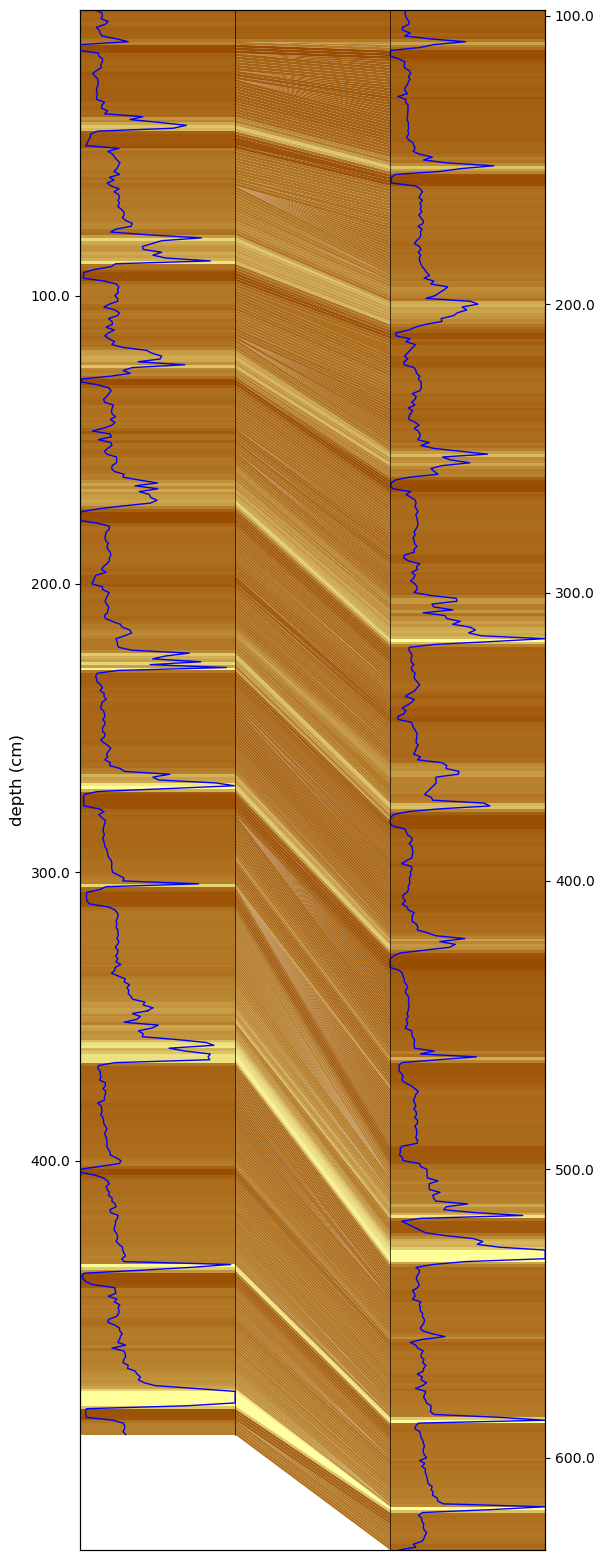

In [115]:
# results depend a lot on how exactly the normalization is done!
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_22), 
                                                    normalize_log(ms_23)[95:], md_22, md_23[95:], exponent = 0.3)
# The correlate_and_plot_logs function is used to analyze and visualize correlations between magnetic susceptibility logs from different wells
# Parameters:
# - log1, log2: The magnetic susceptibility data from two wells to compare
# - depth1, depth2: The corresponding depth values for each log
# - exponent: Controls the normalization strength (default=0.3)
#   - Lower exponent (e.g. 0.3) reduces the impact of extreme values
#   - Higher exponent emphasizes larger variations
#
# In this case:
# - normalize_log() is applied to both ms_22 and ms_23 data to standardize the values
# - ms_23[95:] slices the data to remove noisy surface measurements
# - exponent=0.3 helps highlight meaningful correlations while reducing noise
#
# The function returns:
# - slope: Linear regression slope between the logs
# - intercept: Y-intercept of regression line  
# - r_value: Pearson correlation coefficient (ranges from -1 to 1)
# - p_value: Statistical significance of correlation
# - slope_std_error: Standard error of regression slope
#
# The high r_value (0.73) and low p_value (5.58e-72) here indicate a strong, 
# statistically significant correlation between wells 22 and 23

In [116]:
r_value

0.7342659831047058

In [117]:
p_value

5.577791501337756e-72

In [118]:
# Create dictionaries to record r-values and p-values
r_values_dict = {}
p_values_dict = {}

In [119]:
r_values_dict['22-23'] = r_value
p_values_dict['22-23'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058}
P values: {'22-23': 5.577791501337756e-72}


## 23-25 correlation

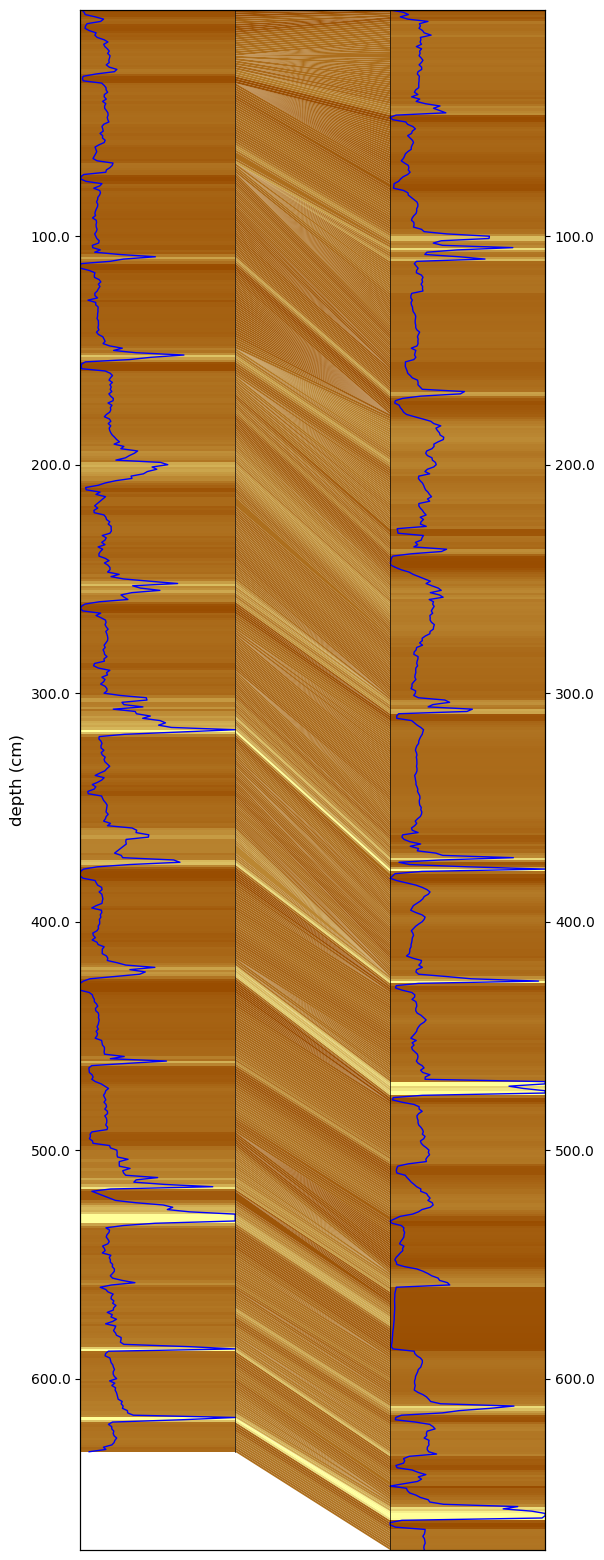

In [120]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_23), 
                                                    normalize_log(ms_25[:670]), md_23, md_25[:670], exponent=0.3)

In [121]:
r_value

0.33414211869239807

In [122]:
p_value

8.059952008946789e-15

In [123]:
r_values_dict['23-25'] = r_value
p_values_dict['23-25'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15}


## 25-22 correlation

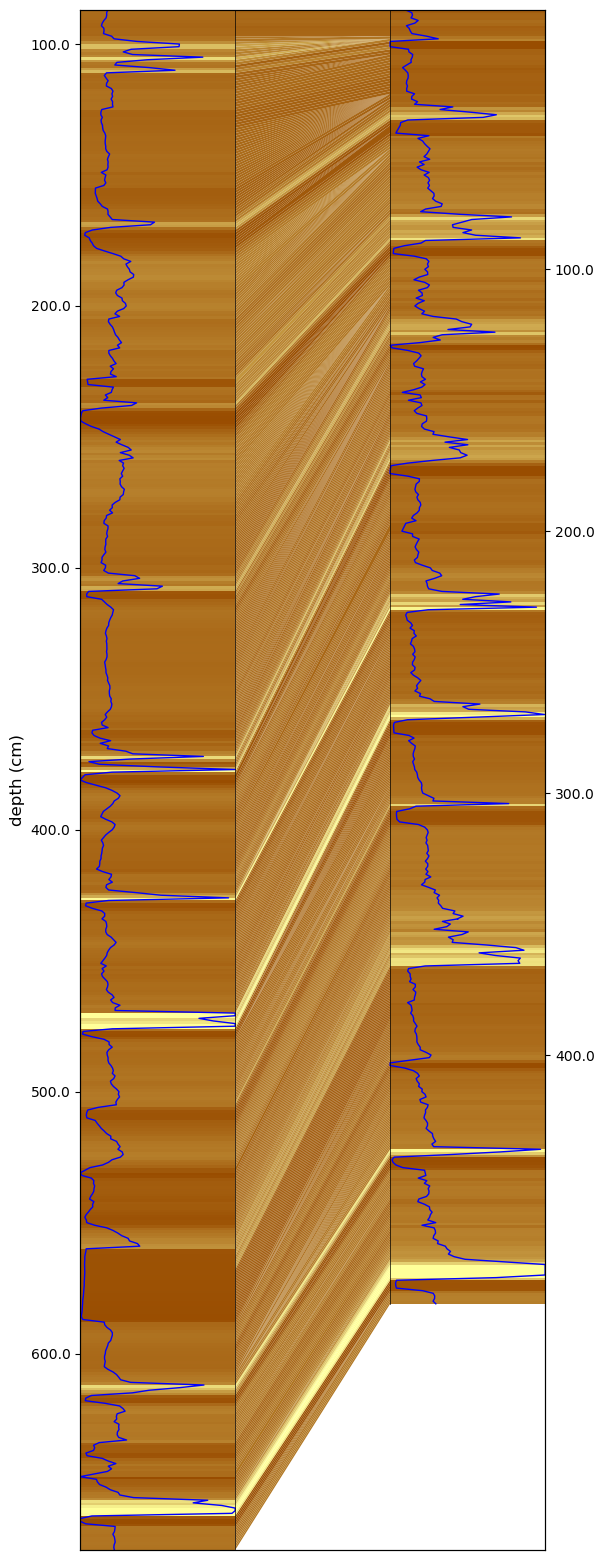

In [124]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_25[:670])[85:], 
                                                    normalize_log(ms_22), md_25[85:670], md_22, exponent=0.3)

In [125]:
r_value

0.5395722985267639

In [126]:
p_value

4.425935864348273e-34

In [127]:
r_values_dict['25-22'] = r_value
p_values_dict['25-22'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807, '25-22': 0.5395722985267639}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15, '25-22': 4.425935864348273e-34}


## 23-12 correlation

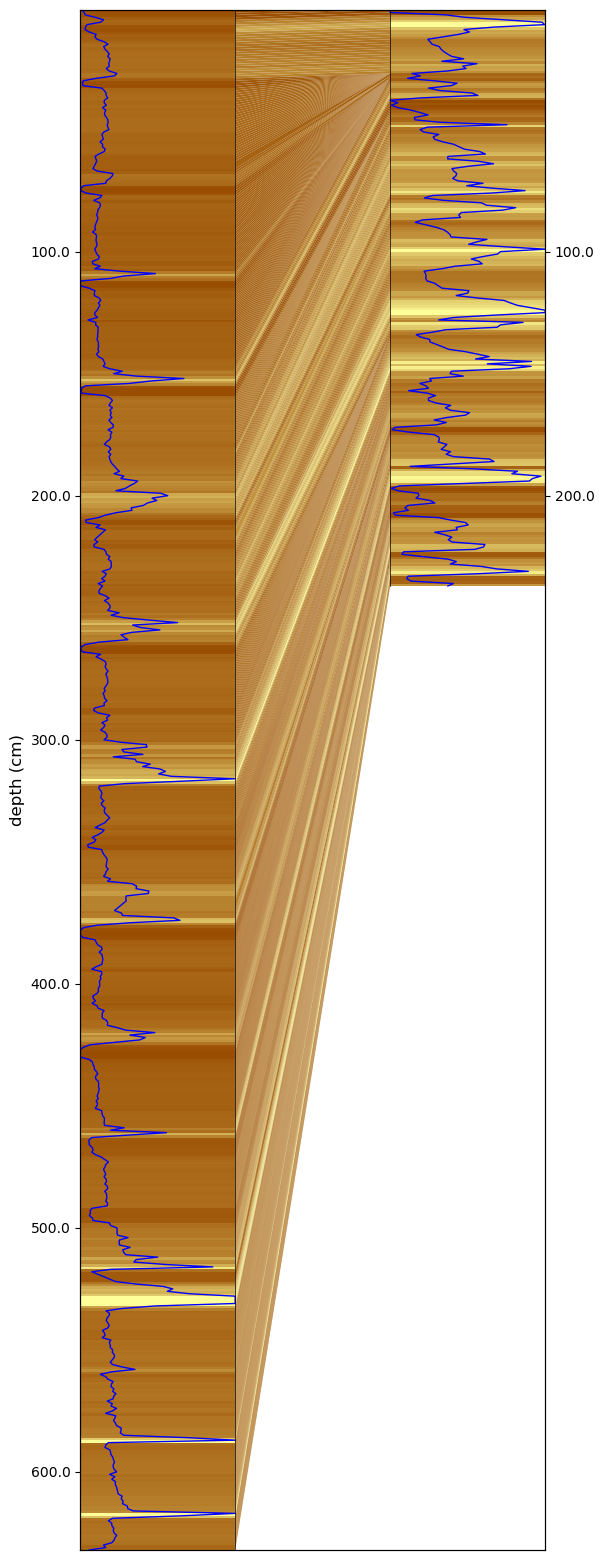

In [128]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_23), 
                                                    normalize_log(ms_12[:236]), md_23, md_12[:236], exponent = 0.3)

In [129]:
r_value

0.3215978145599365

In [130]:
p_value

8.279661540839753e-07

In [131]:
r_values_dict['23-12'] = r_value
p_values_dict['23-12'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807, '25-22': 0.5395722985267639, '23-12': 0.3215978145599365}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15, '25-22': 4.425935864348273e-34, '23-12': 8.279661540839753e-07}


## 12-11 correlation

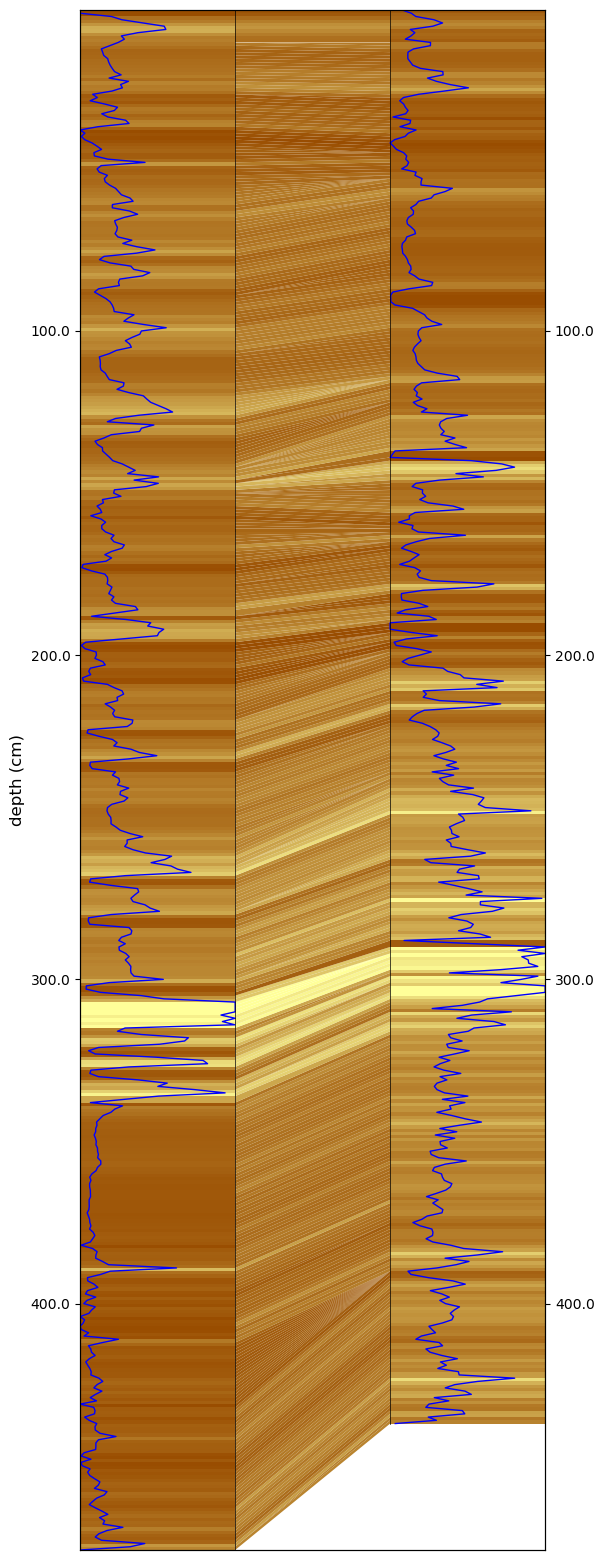

In [132]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_12), 
                                                    normalize_log(ms_11), md_12, md_11, exponent = 0.3)

In [133]:
r_value

0.37181785702705383

In [134]:
p_value

1.1678534344007381e-14

In [135]:
r_values_dict['12-11'] = r_value
p_values_dict['12-11'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807, '25-22': 0.5395722985267639, '23-12': 0.3215978145599365, '12-11': 0.37181785702705383}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15, '25-22': 4.425935864348273e-34, '23-12': 8.279661540839753e-07, '12-11': 1.1678534344007381e-14}


#### This is the Goldfinger et al. correlation (between T6 and T20):

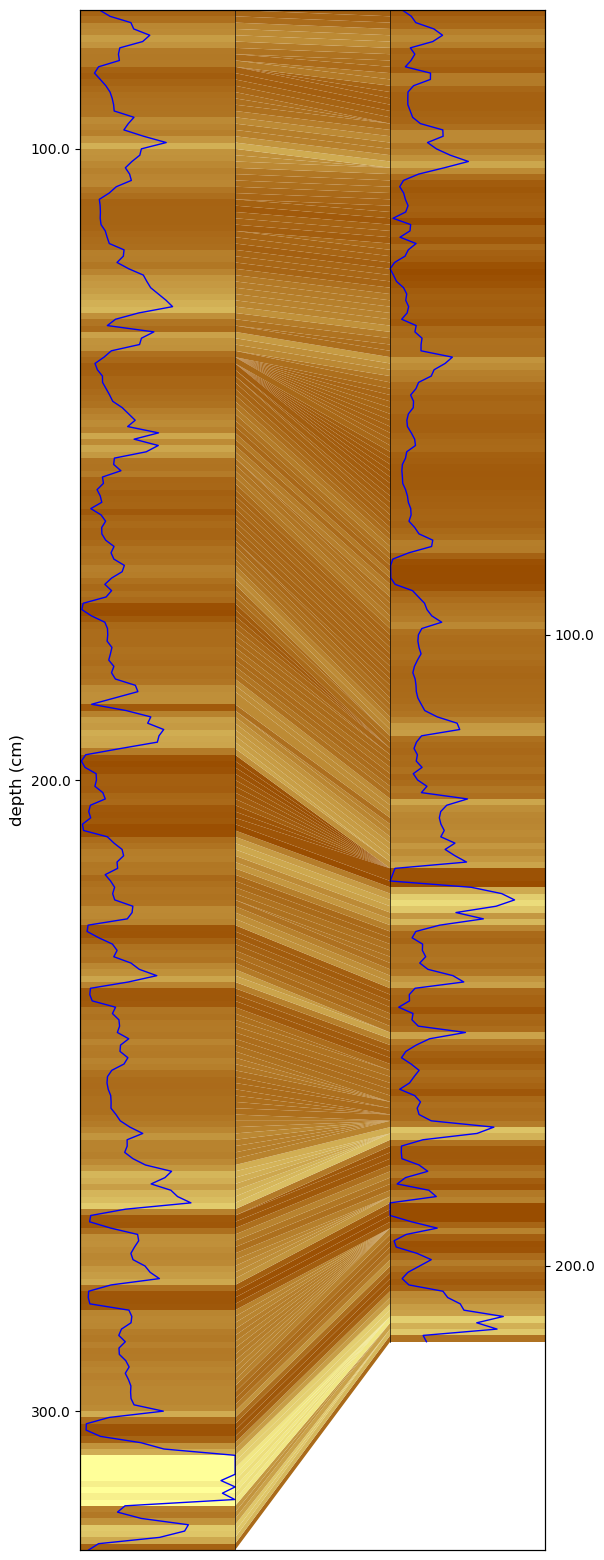

In [136]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_12)[77:321], 
                                            normalize_log(ms_11)[:211], md_12[77:321], md_11[:211], exponent = 0.3)

In [137]:
r_value

0.41455718874931335

#### Correlation of a restricted interval (with better looking correlation than the previous two):

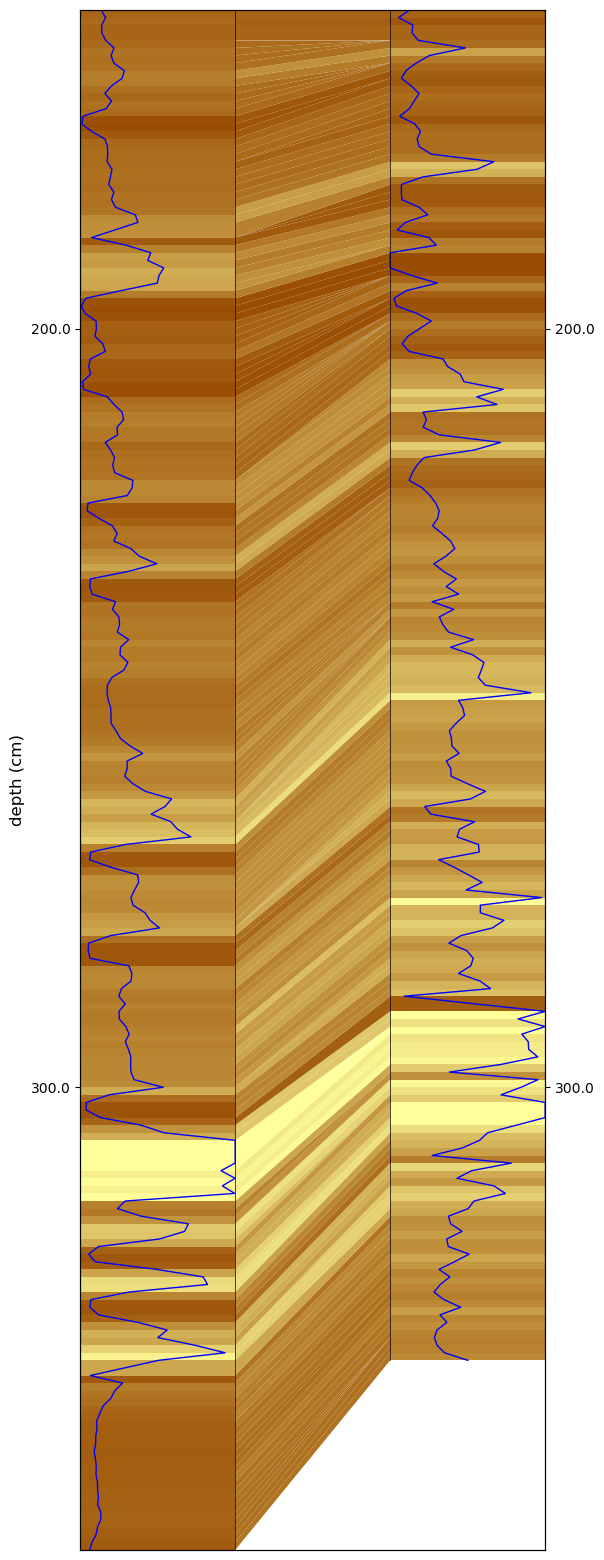

In [138]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_12)[157:359], 
                                            normalize_log(ms_11)[156:334], md_12[157:359], md_11[156:334], exponent = 0.3)

In [139]:
r_value

0.5331745147705078

## 23-14 correlations

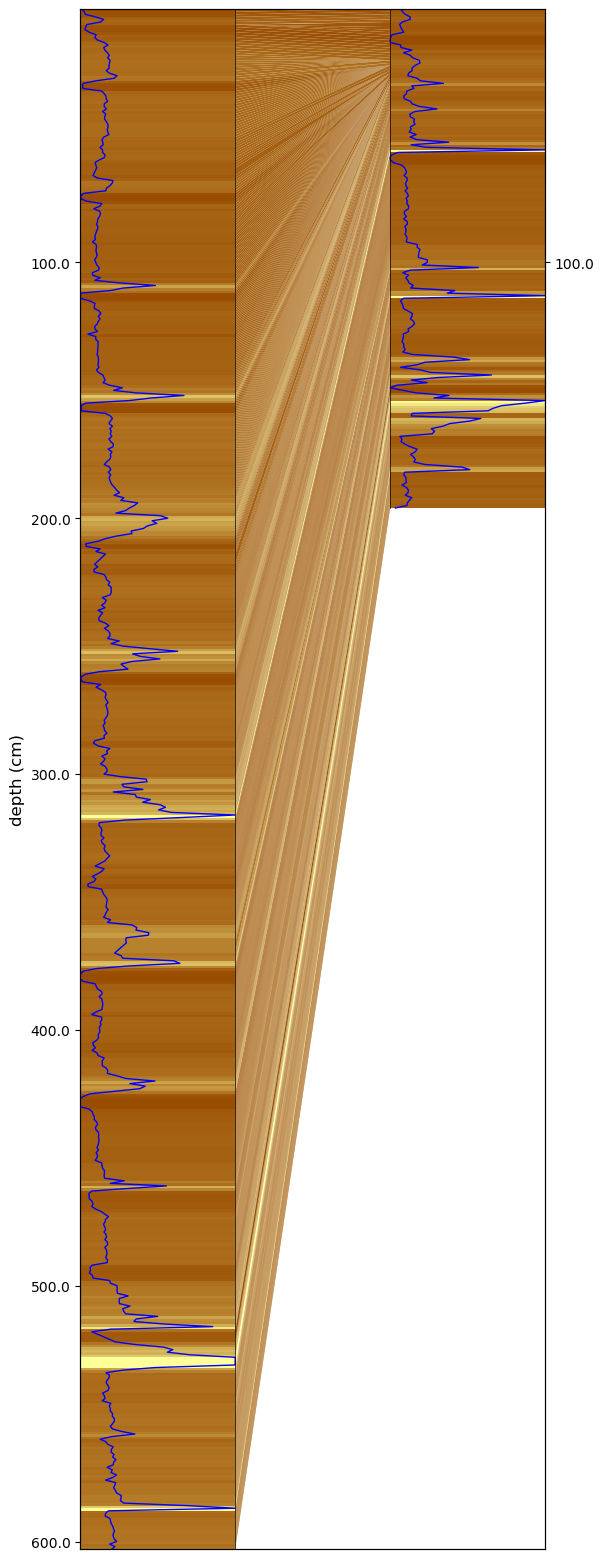

In [140]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_23)[:592], 
                                                    normalize_log(ms_14)[:590], md_23[:592], md_14[:590], exponent = 0.3)

In [141]:
r_value

0.5955173373222351

In [142]:
p_value

2.4852991527884303e-19

In [143]:
r_values_dict['23-14'] = r_value
p_values_dict['23-14'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807, '25-22': 0.5395722985267639, '23-12': 0.3215978145599365, '12-11': 0.37181785702705383, '23-14': 0.5955173373222351}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15, '25-22': 4.425935864348273e-34, '23-12': 8.279661540839753e-07, '12-11': 1.1678534344007381e-14, '23-14': 2.4852991527884303e-19}


## 56-31 correlation

Hydrate Ridge Basin West - Rogue Canyon

If you take away T19 at the bottom of 56, the correlation looks worse (and the correlation coefficient is smaller).

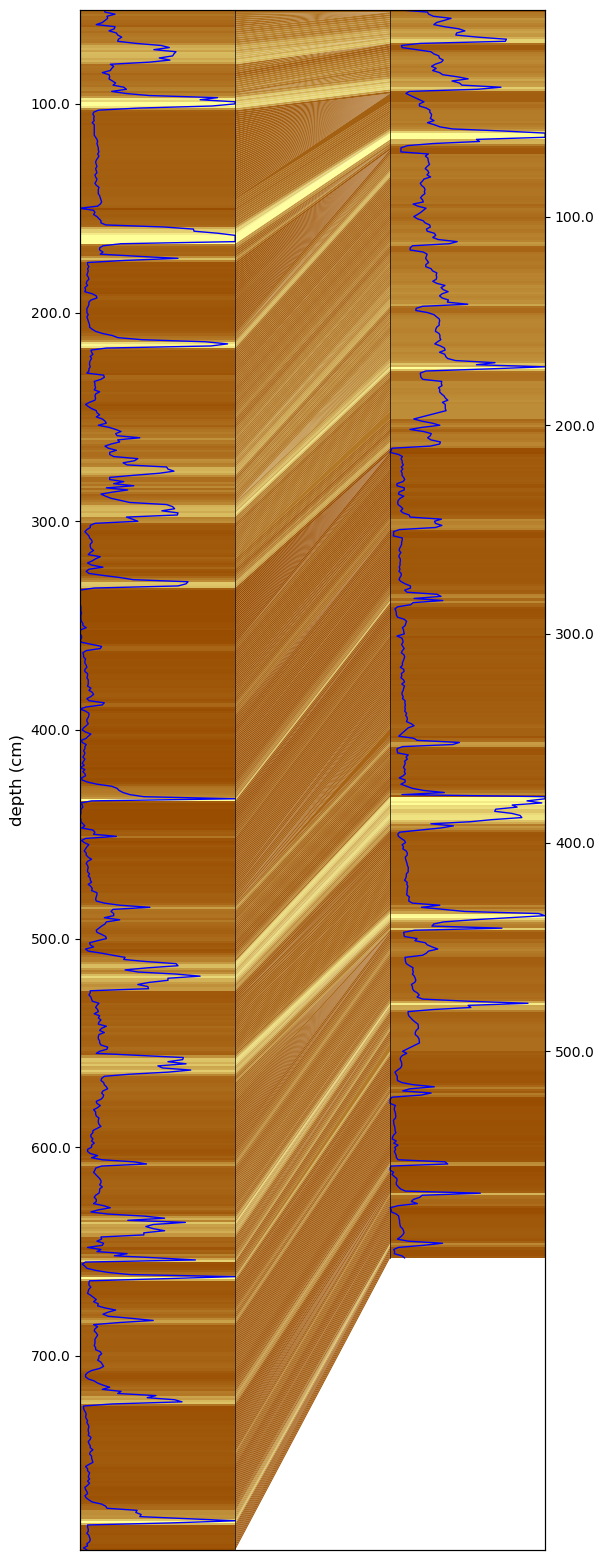

In [144]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_56)[55:], 
                                                normalize_log(ms_31[:587]), md_56[55:], md_31[:587], exponent = 0.3)

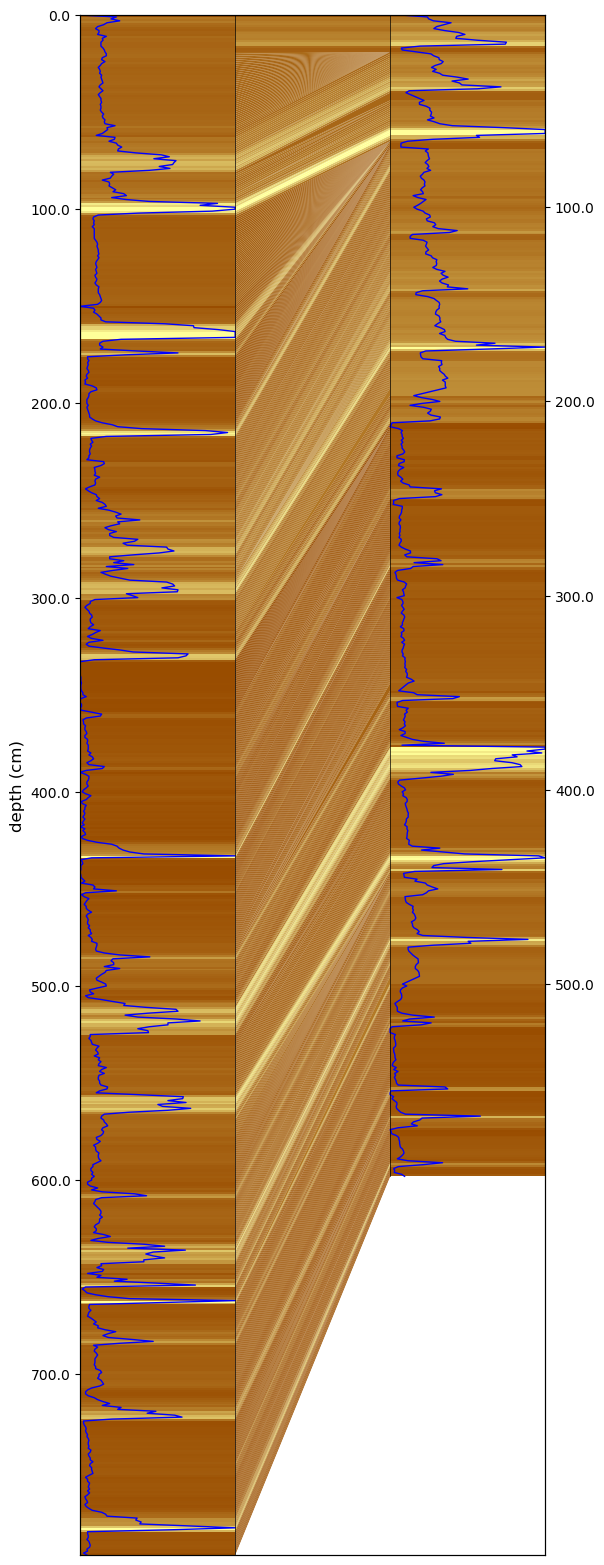

In [145]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_56), 
                                                normalize_log(ms_31[:587]), md_56, md_31[:587], exponent = 0.3)

In [146]:
r_value

0.6381851434707642

In [147]:
p_value

2.044515345628342e-62

In [148]:
r_values_dict['56-31'] = r_value
p_values_dict['56-31'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807, '25-22': 0.5395722985267639, '23-12': 0.3215978145599365, '12-11': 0.37181785702705383, '23-14': 0.5955173373222351, '56-31': 0.6381851434707642}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15, '25-22': 4.425935864348273e-34, '23-12': 8.279661540839753e-07, '12-11': 1.1678534344007381e-14, '23-14': 2.4852991527884303e-19, '56-31': 2.044515345628342e-62}


## 30-31 correlation
Rogue Canyon

In [149]:
# the 30 log needs a lot of fixing; this way it matches Figure 33 in Goldfinger et al. 2012 
md_30 = np.hstack((md_30[:615], md_30[715:]))
ms_30 = np.hstack((ms_30[:615], ms_30[715:]))
inds = np.where((md_30 > 400) & (md_30 < 500))[0]
ms_30[inds] = ms_30[inds[::-1]]

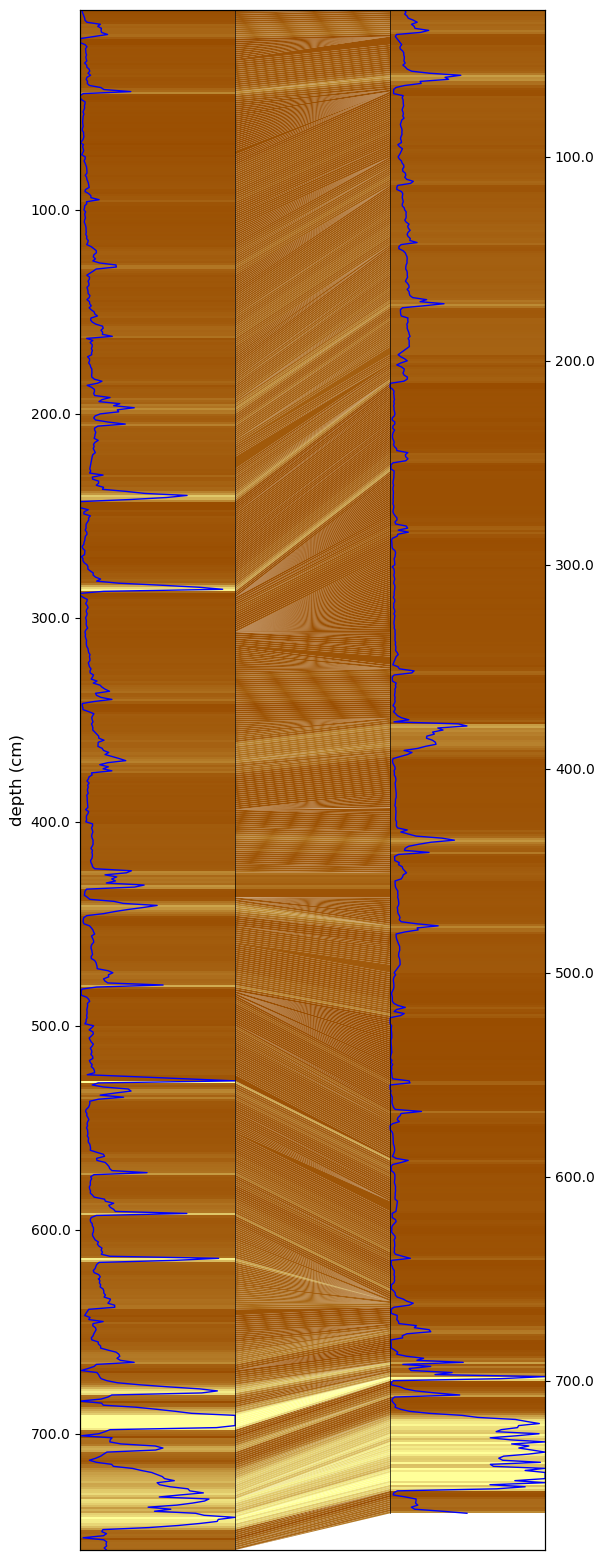

In [150]:
slope, intercept, r_value, p_value, slope_std_error = correlate_and_plot_logs(normalize_log(ms_30[:747]), 
                                            normalize_log(ms_31[27:]), md_30[:747], md_31[27:], exponent = 0.3)

In [151]:
r_value

0.7510565519332886

In [152]:
p_value

1.7304912171837393e-104

In [153]:
r_values_dict['30-31'] = r_value
p_values_dict['30-31'] = p_value
print('R values:', r_values_dict)
print('P values:', p_values_dict)

R values: {'22-23': 0.7342659831047058, '23-25': 0.33414211869239807, '25-22': 0.5395722985267639, '23-12': 0.3215978145599365, '12-11': 0.37181785702705383, '23-14': 0.5955173373222351, '56-31': 0.6381851434707642, '30-31': 0.7510565519332886}
P values: {'22-23': 5.577791501337756e-72, '23-25': 8.059952008946789e-15, '25-22': 4.425935864348273e-34, '23-12': 8.279661540839753e-07, '12-11': 1.1678534344007381e-14, '23-14': 2.4852991527884303e-19, '56-31': 2.044515345628342e-62, '30-31': 1.7304912171837393e-104}


## Randomization

### Create 'database' of individual turbidites

In [154]:
def onclick_boundary(event, xs, fig):
    """function for collecting depth values for a stratigraphic top from a chronostratigraphic diagram

    :param event: mouse click event
    :param xs: x coordinates of points clicked in cross section
    :param ys: y coordinates (depth values) of points clicked in cross section
    :param fig: figure handle of cross section"""
    x1 = event.xdata
    xs.append(x1)
    ax = fig.axes[0]
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([x1, x1], [-30, 600], 'r')
    fig.canvas.draw_idle()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
def create_figure_for_clicking(md, log, miny, maxy):
    fig = plt.figure(figsize=(18,3))
    plt.plot(md, log)
    plt.ylim(miny, maxy)
    plt.xlim(md[0], md[-1])
    plt.xlabel('depth(cm)')
    return fig
    

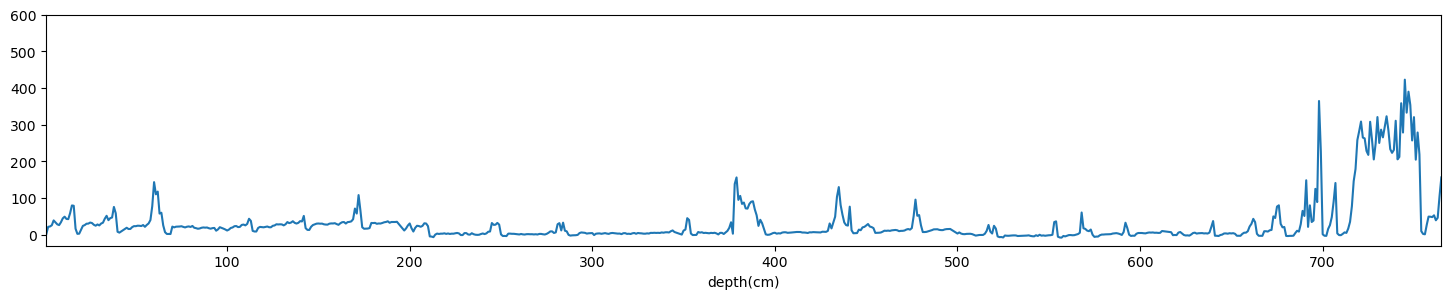

In [155]:
# code for manually interpreting turbidite tops (see collected data below)
fig = create_figure_for_clicking(md_31, ms_31, -30, 600)
xs = []
cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick_boundary(event, xs, fig))

In [156]:
tops_22 = [0.0, 13.040143369175638, 43.848745519713276, 91.6551971326165, 129.19211469534054, 
           175.5820788530466, 231.53333333333336, 273.673835125448, 307.31541218637994, 
           367.5161290322581, 403.28243727598567, 439.4028673835126, 486.50107526881726]

tops_23 = [7.784946236559151, 30.40143369175628, 73.37275985663082, 112.27311827956989, 
           155.69677419354838, 209.97634408602153, 261.089605734767, 318.9878136200717, 
           376.88602150537633, 426.64229390681, 463.28100358422944, 492.68243727598565, 
           518.0129032258064, 533.8444444444444, 559.6272401433691, 587.6716845878136, 
           618.8824372759857, 632]

tops_25 = [0, 47.103225806451604, 111.98924731182797, 171.752688172043, 240.05376344086022, 
           308.92401433691754, 380.64014336917563, 427.8817204301076, 476.8308243727599, 
           506.9971326164875, 529.7641577060931, 559.9304659498207, 615.7096774193549, 
           662.9512544802867, 684.5799283154122, 706.7777777777778, 743.2050179211469, 
           780.7706093189963]

tops_56 = [0, 80.721146953405, 104.02795698924729, 176.2222222222222, 218.2881720430107, 
           302.4200716845878, 333.6853046594981, 435.43942652329747, 525.2559139784946, 
           567.3218637992832, 609.9562724014337, 643.495340501792, 655.4329749103943, 
           664.5283154121863, 685.5612903225806, 724.2164874551971, 781.6308243727598]

tops_30 = [0, 15.574193548387086, 44.419354838709666, 96.4537634408602, 129.82365591397848, 
           163.19354838709677, 206.74408602150538, 243.50752688172042, 288.18924731182796, 
           341.92043010752684, 376.9870967741935, 431.8494623655914, 462.95698924731175, 
           478.79354838709673, 537.6150537634409, 574.3784946236559, 594.174193548387, 
           616.2322580645161, 639.421505376344, 667.1354838709677]

tops_31 = [0, 17.430107526881727, 39.88458781362007, 65.62508960573479, 113.82007168458782, 
           143.941935483871, 174.0637992831541, 210.75770609318997, 250.1899641577061, 
           286.33620071684595, 354.247311827957, 394.77491039426525, 441.8745519713261, 
           481.3068100358423, 522.3820788530466, 555.24229390681, 573.863082437276, 
           595.2222222222222, 641.226523297491, 664.2286738351255, 680.6587813620072, 700.3749103942653]

In [157]:
# xs = [0] + xs
# tops_31 = xs
print(tops_31)

[0, 17.430107526881727, 39.88458781362007, 65.62508960573479, 113.82007168458782, 143.941935483871, 174.0637992831541, 210.75770609318997, 250.1899641577061, 286.33620071684595, 354.247311827957, 394.77491039426525, 441.8745519713261, 481.3068100358423, 522.3820788530466, 555.24229390681, 573.863082437276, 595.2222222222222, 641.226523297491, 664.2286738351255, 680.6587813620072, 700.3749103942653]


In [158]:
turb_logs = []
depth_logs = []
log_number = []

def add_turbidites_to_database(turb_logs, depth_logs, log_number, log, md, tops):
    count = 0
    for i in range(len(tops) - 1):
        turb_logs.append(log[(md < tops[i+1]) & (md >= tops[i])])
        depth_log = md[(md < tops[i+1]) & (md >= tops[i])]
        depth_log = depth_log - min(depth_log)
        depth_logs.append(depth_log)
        log_number.append(count)
        count += 1

add_turbidites_to_database(turb_logs, depth_logs, log_number, ms_22, md_22, tops_22)
add_turbidites_to_database(turb_logs, depth_logs, log_number, ms_23, md_23, tops_23)
add_turbidites_to_database(turb_logs, depth_logs, log_number, ms_25, md_25, tops_25)
add_turbidites_to_database(turb_logs, depth_logs, log_number, ms_56, md_56, tops_56)
add_turbidites_to_database(turb_logs, depth_logs, log_number, ms_30, md_30, tops_30)
add_turbidites_to_database(turb_logs, depth_logs, log_number, ms_31, md_31, tops_31)

In [159]:
len(depth_logs)

102

In [160]:
def plot_logs_w_turb_boundaries(md, log, tops):
    fig = plt.figure(figsize=(15, 6))
    plt.plot(md, normalize_log(log), '.-')
    plt.ylim(0, 1)
    count = 0
    for i in range(len(tops)):
        plt.plot([tops[i], tops[i]], [0, 1], 'r' )
        plt.text(tops[i], 0.2, str(count))
        count += 1
    return fig

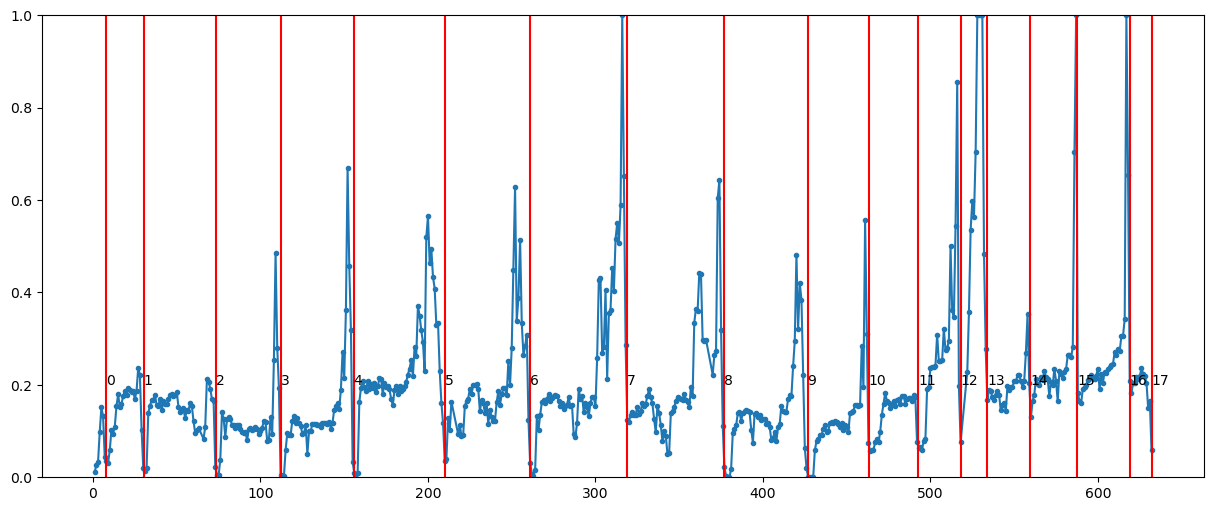

In [161]:
# check how the tops look like when plotted on the log
fig = plot_logs_w_turb_boundaries(md_23, ms_23, tops_23)

In [162]:
from tqdm import trange

def process_single_shuffled_iteration(i, md, log, thickness, exponent, same_log_turb_logs, same_log_depth_logs):
    log1 = normalize_log(log)
    d1 = md
    fake_log = np.array([])
    md_log = np.array([])
    max_depth = 0
    while max_depth <= thickness:
        ind = random.choices(np.arange(len(same_log_turb_logs)), k=1)[0]
        fake_log = np.hstack((fake_log, same_log_turb_logs[ind].flatten()))
        if len(md_log) == 0:
            md_log = np.hstack((md_log, 1 + same_log_depth_logs[ind]))
        else:
            md_log = np.hstack((md_log, 1 + md_log[-1] + same_log_depth_logs[ind]))
        max_depth = md_log[-1]
    log2 = normalize_log(fake_log)
    d2 = md_log
    p, q, D = correlate_logs(log1, log2, exponent)
    vsh_means1 = log1[p]
    vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
    vsh_means2 = log2[q]
    vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
    _, _, r_value, _, _ = stats.linregress(vsh_means1[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)], 
                                                                      vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)])
    return r_value

def correlate_log_w_shuffled_log(md, log, tops, thickness, nit, exponent):
    """
    Correlate original log with shuffled synthetic logs created from the same log's turbidites.
    This version uses only the turbidites from the same log to create shuffled synthetic logs.
    
    Parameters:
    -----------
    md : array-like
        Measured depth array for the original log
    log : array-like
        Original log data
    tops : array-like
        Turbidite boundaries for the original log
    thickness : float
        Target thickness for synthetic logs
    nit : int
        Number of iterations (synthetic logs to generate)
    exponent : float
        Exponent parameter for DTW correlation
    
    Returns:
    --------
    list
        List of correlation coefficients (r_values) from each iteration
    """
    from joblib import Parallel, delayed
    
    # Create turbidite database from the same log only
    same_log_turb_logs = []
    same_log_depth_logs = []
    
    for i in range(len(tops) - 1):
        turb_segment = log[(md < tops[i+1]) & (md >= tops[i])]
        depth_segment = md[(md < tops[i+1]) & (md >= tops[i])]
        depth_segment = depth_segment - min(depth_segment)
        same_log_turb_logs.append(turb_segment)
        same_log_depth_logs.append(depth_segment)
    
    # Use joblib for parallel processing
    r_values = Parallel(n_jobs=-1)(
        delayed(process_single_shuffled_iteration)(
            i, md, log, thickness, exponent, same_log_turb_logs, same_log_depth_logs
        ) for i in trange(nit)
    )
    
    return r_values


In [163]:
from tqdm import trange

def process_single_iteration(i, md, log, thickness, exponent, turb_logs, depth_logs):
    log1 = normalize_log(log)
    d1 = md
    fake_log = np.array([])
    md_log = np.array([])
    max_depth = 0
    while max_depth <= thickness:
        ind = random.choices(np.arange(len(turb_logs)), k=1)[0]
        fake_log = np.hstack((fake_log, turb_logs[ind].flatten()))
        if len(md_log) == 0:
            md_log = np.hstack((md_log, 1 + depth_logs[ind]))
        else:
            md_log = np.hstack((md_log, 1 + md_log[-1] + depth_logs[ind]))
        max_depth = md_log[-1]
    log2 = normalize_log(fake_log)
    d2 = md_log
    p, q, D = correlate_logs(log1, log2, exponent)
    vsh_means1 = log1[p]
    vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
    vsh_means2 = log2[q]
    vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
    _, _, r_value, _, _ = stats.linregress(vsh_means1[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)], 
                                                                      vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)])
    return r_value

def correlate_log_w_synthetic_logs(md, log, thickness, nit, exponent, turb_logs, depth_logs):
    from joblib import Parallel, delayed
    
    # Use joblib for parallel processing
    r_values = Parallel(n_jobs=-1)(
        delayed(process_single_iteration)(
            i, md, log, thickness, exponent, turb_logs, depth_logs
        ) for i in trange(nit)
    )
    
    return r_values

In [164]:
def correlate_synth_log_w_synth_logs(thickness, nit, exponent, turb_logs, depth_logs):
    """
    correlate synthetic log pairs
    """
    from joblib import Parallel, delayed
    
    # Use joblib for parallel processing
    r_values = Parallel(n_jobs=-1)(
        delayed(process_synthetic_iteration)(
            i, thickness, exponent, turb_logs, depth_logs
        ) for i in trange(nit)
    )
    
    return r_values

def process_synthetic_iteration(i, thickness, exponent, turb_logs, depth_logs):
    # create first log:
    log1, _, inds = create_synthetic_log(thickness, turb_logs, depth_logs)
    
    # create second log with different turbidites:
    log2, _, _ = create_synthetic_log(thickness, turb_logs, depth_logs, exclude_inds=inds)
    
    # correlate the logs
    p, q, _ = correlate_logs(log1, log2, exponent)
    
    # calculate statistics
    vsh_means1 = log1[p]
    vsh_means1[np.where(np.diff(p)==0)[0] + 1] = np.nan
    vsh_means2 = log2[q]
    vsh_means2[np.where(np.diff(q)==0)[0] + 1] = np.nan
    
    _, _, r_value, _, _ = stats.linregress(
        vsh_means1[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)], 
        vsh_means2[(np.isnan(vsh_means1)==0) & (np.isnan(vsh_means2)==0)]
    )
        
    return r_value

def create_synthetic_log(thickness, turb_logs, depth_logs, exclude_inds=None):
    fake_log = np.array([])
    md_log = np.array([])
    max_depth = 0
    inds = []
    
    while max_depth <= thickness:
        ind = random.choices(np.arange(len(turb_logs)), k=1)[0]
        
        # Skip if this index should be excluded
        if exclude_inds is not None and ind in exclude_inds:
            continue
            
        inds.append(ind)
        fake_log = np.hstack((fake_log, turb_logs[ind].flatten()))
        
        if len(md_log) == 0:
            md_log = np.hstack((md_log, 1 + depth_logs[ind]))
        else:
            md_log = np.hstack((md_log, 1 + md_log[-1] + depth_logs[ind]))
            
        max_depth = md_log[-1]
        
    log = normalize_log(fake_log)
    d = md_log.copy()
    
    return log, d, inds


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import pandas as pd

def plot_turbidite_correlation_distribution(r_values_data, data_type="synthetic_to_synthetic", 
                                          actual_correlations=None,
                                          save_figure=True, figure_name=None,
                                          core_name=None, save_csv=False, csv_name=None,
                                          pdf_method='KDE', kde_bandwidth=0.05):
    """
    Plot distribution of correlation coefficients from turbidite correlation analysis.
    
    Parameters:
    -----------
    r_values_data : list or array
        List/array of correlation coefficients (r-values) from randomization analysis
    data_type : str
        Type of data being plotted ("synthetic_to_synthetic", "log_vs_synthetic", "log_to_shuffled", etc.)
    actual_correlations : dict, optional
        Dictionary of actual core correlation r-values (e.g., r_values_dict from notebook)
    save_figure : bool
        Whether to save the figure as PNG
    figure_name : str, optional
        Custom filename for saved figure
    core_name : str, optional
        Name of the core when comparing actual logs to synthetic logs
    save_csv : bool
        Whether to save the r_values_data as CSV file
    csv_name : str, optional
        Custom filename for saved CSV file
    pdf_method : str
        Method for probability density function overlay: 'KDE' (default), 'skew-normal', or 'normal'
    kde_bandwidth : float
        Bandwidth for KDE when pdf_method='KDE' (default: 0.05)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    fit_params : dict
        Dictionary containing fitted parameters (location, scale, shape for skew-normal; mean, std for normal; bandwidth for KDE)
    """
    
    # Convert to numpy array for easier handling
    r_values = np.array(r_values_data)
    
    # Remove any NaN values
    r_values = r_values[~np.isnan(r_values)]
    
    # Save CSV if requested
    if save_csv:
        if csv_name is None:
            csv_name = f'r_values_{data_type}.csv'
        
        # Create DataFrame and save
        df = pd.DataFrame({'r_values': r_values})
        df.to_csv(csv_name, index=False)
        print(f"R-values data saved as: {csv_name}")
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calculate total count for percentage
    total_count = len(r_values)
    
    # Plot histogram of correlation coefficients as percentage
    hist, bins, _ = ax.hist(r_values, bins=50, alpha=0.7, color='skyblue', 
                            edgecolor='black', weights=np.ones(total_count)*100/total_count)
    
    # Initialize fit_params dictionary
    fit_params = {}
    
    # Add probability density function curve based on method
    if len(r_values) > 1:  # Only plot PDF if we have multiple values
        x = np.linspace(r_values.min(), r_values.max(), 1000)
        
        # Calculate area under the histogram in percentage terms
        bin_width = bins[1] - bins[0]
        hist_area = np.sum(hist) * bin_width
        
        if pdf_method.upper() == 'KDE':
            # Use Kernel Density Estimation (current method)
            kde = stats.gaussian_kde(r_values, bw_method=kde_bandwidth)
            y = kde(x) * hist_area
            fit_params['method'] = 'KDE'
            fit_params['bandwidth'] = kde_bandwidth
            
            ax.plot(x, y, 'r-', linewidth=2, alpha=0.8, 
                    label=f'KDE\n(bandwidth = {kde_bandwidth})\n(n = {total_count:,})')
        
        elif pdf_method.upper() == 'SKEW-NORMAL':
            # Fit skew-normal distribution
            try:
                # Fit skew-normal distribution using maximum likelihood estimation
                # Let scipy determine the best fit parameters automatically
                shape, location, scale = stats.skewnorm.fit(r_values)
                
                # Generate PDF
                y = stats.skewnorm.pdf(x, shape, location, scale) * hist_area
                
                fit_params['method'] = 'skew-normal'
                fit_params['shape'] = shape
                fit_params['location'] = location
                fit_params['scale'] = scale
                fit_params['skewness'] = shape / np.sqrt(1 + shape**2) * np.sqrt(2/np.pi)
                
                ax.plot(x, y, 'r-', linewidth=2, alpha=0.8, 
                        label=f'Skew-Normal Fit\n(α = {shape:.3f})\n(μ = {location:.3f})\n(σ = {scale:.3f})\n(n = {total_count:,})')
                
            except (RuntimeError, ValueError, TypeError) as e:
                print(f"Warning: Skew-normal fitting failed: {e}")
                print("Falling back to normal distribution fit")
                pdf_method = 'normal'
        
        if pdf_method.upper() == 'NORMAL':
            # Fit normal distribution
            mean_val, std_val = stats.norm.fit(r_values)
            
            # Generate PDF
            y = stats.norm.pdf(x, mean_val, std_val) * hist_area
            
            fit_params['method'] = 'normal'
            fit_params['mean'] = mean_val
            fit_params['std'] = std_val
            
            ax.plot(x, y, 'r-', linewidth=2, alpha=0.8, 
                    label=f'Normal Fit\n(μ = {mean_val:.3f})\n(σ = {std_val:.3f})\n(n = {total_count:,})')
    
    # Calculate statistics for legend
    median_corr = np.median(r_values)
    mean_corr = np.mean(r_values)
    std_corr = np.std(r_values)
    
    # Add vertical line for median
    ax.axvline(median_corr, color='b', linestyle='-', linewidth=2, 
               label=f'Median: {median_corr:.3f}')
    
    # Add vertical line for mean
    ax.axvline(mean_corr, color='green', linestyle='-', linewidth=2,
               label=f'Mean: {mean_corr:.3f}\nσ: {std_corr:.3f}')
    
    # Add vertical line for 97.5th percentile (significance threshold)
    percentile_975 = np.percentile(r_values, 97.5)
    ax.axvline(percentile_975, color='k', linestyle='dashed', linewidth=2,
               label=f'P97.5: {percentile_975:.3f}')
    
    # Track legend entries for significance
    significant_pairs = []
    non_significant_pairs = []
    
    # If actual correlations are provided, plot them
    if actual_correlations is not None:
        for pair_name, r_value in actual_correlations.items():
            if isinstance(r_value, (int, float)) and not np.isnan(r_value):
                # Calculate percentile for this correlation
                percentile = (r_values < r_value).mean() * 100
                
                # Determine significance
                is_significant = r_value > percentile_975
                
                if is_significant:
                    linestyle = 'solid'
                    alpha = 0.85
                    significant_pairs.append(pair_name)
                else:
                    linestyle = 'dotted'
                    alpha = 0.6
                    non_significant_pairs.append(pair_name)
                
                # Plot the line
                line = ax.axvline(r_value, color='orange', linestyle=linestyle, 
                                 linewidth=2, alpha=alpha)
                
                # Add text annotation for pair name along the line
                y_pos = ax.get_ylim()[1] * 0.9  # Position near top of plot
                ax.text(r_value, y_pos, pair_name, rotation=90, 
                       verticalalignment='top', horizontalalignment='center',
                       fontsize=8, alpha=alpha, color='darkred', fontweight='normal',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))
    
    # Add legend entries for significance levels
    if significant_pairs:
        # Create a dummy line for legend
        ax.plot([], [], color='orange', linestyle='solid', linewidth=1.5, alpha=0.85,
               label=f'p < 0.05$^{{**}}$')
    
    if non_significant_pairs:
        # Create a dummy line for legend
        ax.plot([], [], color='orange', linestyle='dotted', linewidth=1.5, alpha=0.6,
               label=f'p ≥ 0.05')
    
    # Set x-axis limits
    x_min = 0
    x_max = 1.0
    ax.set_xlim(x_min, x_max)
    
    # Add labels and title
    ax.set_xlabel('Correlation Coefficient (r)', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    
    if data_type == "synthetic_to_synthetic":
        title = 'Distribution of Correlation Coefficients\nSynthetic Log Pairs (Randomization Test)'
    elif data_type == "log_vs_synthetic":
        if core_name:
            title = f'Distribution of Correlation Coefficients\nActual Log ({core_name}) vs Synthetic Logs'
        else:
            title = 'Distribution of Correlation Coefficients\nActual Logs vs Synthetic Logs'
    elif data_type == "log_to_shuffled":
        if core_name:
            title = f'Distribution of Correlation Coefficients\nActual Log ({core_name}) vs Shuffled Log'
        else:
            title = 'Distribution of Correlation Coefficients\nActual Log vs Shuffled Log'
    else:
        title = f'Distribution of Correlation Coefficients\n{data_type}'
    
    plt.title(title, fontsize=14, pad=20)
    
    # Create legend with better positioning
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Save the figure if requested
    if save_figure:
        if figure_name is None:
            figure_name = f'turbidite_correlation_distribution_{data_type}_{pdf_method.lower()}.png'
        
        plt.savefig(figure_name, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved as: {figure_name}")
    
    # Print summary statistics
    print(f"\nSummary Statistics for {data_type} Correlation Coefficients:")
    print(f"{'='*60}")
    print(f"Number of correlations: {total_count:,}")
    print(f"Median: {median_corr:.3f}")
    print(f"Mean: {mean_corr:.3f}")
    print(f"Standard Deviation: {std_corr:.3f}")
    print(f"Min: {r_values.min():.3f}")
    print(f"Max: {r_values.max():.3f}")
    print(f"95th percentile: {percentile_975:.3f}")
    print(f"99th percentile: {np.percentile(r_values, 99):.3f}")
    
    # Print distribution fitting results
    if fit_params:
        print(f"\nDistribution Fitting Results ({fit_params['method']}):")
        print(f"{'='*60}")
        if fit_params['method'] == 'KDE':
            print(f"Bandwidth: {fit_params['bandwidth']} (Controls smoothness of the density curve)")
        elif fit_params['method'] == 'skew-normal':
            print(f"Shape parameter (α): {fit_params['shape']:.5f} (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)")
            print(f"Location parameter (μ): {fit_params['location']:.5f} (Center/peak position of the distribution; larger magnitude shifts distribution)")
            print(f"Scale parameter (σ): {fit_params['scale']:.5f} (Width/spread of the distribution; magnitude indicates the degree of spread)")
            print(f"Skewness: {fit_params['skewness']:.5f} (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)")
        elif fit_params['method'] == 'normal':
            print(f"Mean (μ): {fit_params['mean']:.5f} (Center of the distribution; magnitude indicates distance from zero)")
            print(f"Standard deviation (σ): {fit_params['std']:.5f} (Width/spread of the distribution; larger magnitude increases variability)")
    
    # If actual correlations are provided, show their percentiles and significance
    if actual_correlations is not None:
        print(f"\nActual Core Pair Correlations vs {data_type} Distribution:")
        print(f"{'='*60}")
        for pair_name, r_value in actual_correlations.items():
            if isinstance(r_value, (int, float)) and not np.isnan(r_value):
                percentile = (r_values < r_value).mean() * 100
                p_value = (r_values >= r_value).mean()
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                print(f"{pair_name:<12}: r = {r_value:.5f}, {percentile:5.1f}th percentile, p = {p_value:.3f} {significance}")
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax, fit_params


def plot_comparison_with_actual_correlations(r_values_synthetic, actual_correlations_dict):
    """
    Create a comparison plot showing both synthetic and actual correlations.
    
    Parameters:
    -----------
    r_values_synthetic : array-like
        Array of synthetic correlation coefficients
    actual_correlations_dict : dict
        Dictionary of actual core pair correlations from the notebook
    """
    
    # Example usage with the data from the notebook
    fig, ax = plot_turbidite_correlation_distribution(
        r_values_data=r_values_synthetic,
        data_type="synthetic_pairs",
        actual_correlations=actual_correlations_dict,
        save_figure=True,
        figure_name="cascadia_turbidite_correlations_vs_synthetic.png"
    )
    
    return fig, ax


100%|██████████| 10000/10000 [00:17<00:00, 557.09it/s]


R-values data saved as: outputs/r-values_CSZ_Null_Hypothesis_logshuffled_M9907-23PC.csv
Figure saved as: outputs/r-values_CSZ_Null_Hypothesis_logshuffled_M9907-23PC.png

Summary Statistics for log_to_shuffled Correlation Coefficients:
Number of correlations: 10,000
Median: 0.497
Mean: 0.496
Standard Deviation: 0.125
Min: 0.047
Max: 0.893
95th percentile: 0.728
99th percentile: 0.766

Distribution Fitting Results (skew-normal):
Shape parameter (α): -0.94002 (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)
Location parameter (μ): 0.57719 (Center/peak position of the distribution; larger magnitude shifts distribution)
Scale parameter (σ): 0.14896 (Width/spread of the distribution; magnitude indicates the degree of spread)
Skewness: -0.54648 (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)


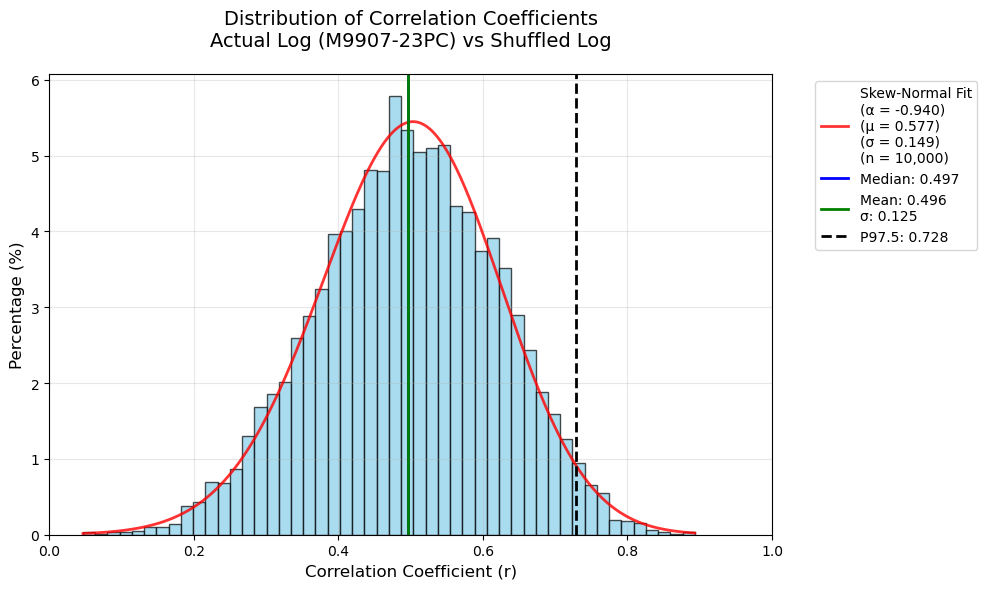

100%|██████████| 10000/10000 [00:16<00:00, 609.05it/s]


R-values data saved as: outputs/r-values_CSZ_Null_Hypothesis_logshuffled_M9907-25PC.csv
Figure saved as: outputs/r-values_CSZ_Null_Hypothesis_logshuffled_M9907-25PC.png

Summary Statistics for log_to_shuffled Correlation Coefficients:
Number of correlations: 10,000
Median: 0.439
Mean: 0.440
Standard Deviation: 0.116
Min: 0.046
Max: 0.867
95th percentile: 0.670
99th percentile: 0.710

Distribution Fitting Results (skew-normal):
Shape parameter (α): 0.64076 (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)
Location parameter (μ): 0.38492 (Center/peak position of the distribution; larger magnitude shifts distribution)
Scale parameter (σ): 0.12901 (Width/spread of the distribution; magnitude indicates the degree of spread)
Skewness: 0.43047 (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)


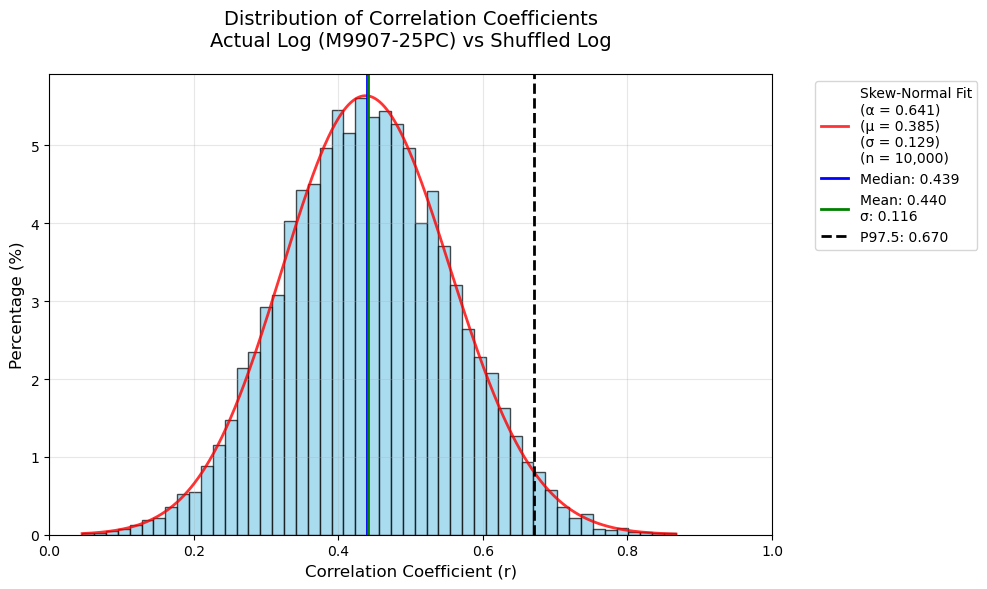

In [166]:
# core_numbers = ["22", "23", "25", "11", "12", "14", "56", "02", "30", "31", "09"]
core_numbers = ["23", "25"]

for core_number in core_numbers:
    md_var = f"md_{core_number}"
    ms_var = f"ms_{core_number}" 
    tops_var = f"tops_{core_number}"
    r_values_logshuffled = correlate_log_w_shuffled_log(locals()[md_var], locals()[ms_var], locals()[tops_var], 700, 10000, 0.3)

    core_name = f"core_name_{core_number}"

    # Plot log-shuffled correlations
    fig3, ax3, fit_params3 = plot_turbidite_correlation_distribution(
        r_values_data=r_values_logshuffled,
        data_type="log_to_shuffled",     #log_to_shuffled, log_to_synthetic, synthetic_to_synthetic
        pdf_method='skew-normal',        #'KDE', 'skew-normal', 'normal'
        kde_bandwidth=0.1,               #only work for KDE pdf_method
        save_figure=True,
        figure_name=f"outputs/r-values_CSZ_Null_Hypothesis_logshuffled_{locals()[core_name]}.png",
        core_name=locals()[core_name],
        save_csv=True,
        csv_name=f"outputs/r-values_CSZ_Null_Hypothesis_logshuffled_{locals()[core_name]}.csv"
    )


100%|██████████| 10000/10000 [00:07<00:00, 1326.19it/s]


R-values data saved as: outputs/r-values_CSZ_Null_Hypothesis_logsyn_M9907-22PC.csv
Figure saved as: outputs/r-values_CSZ_Null_Hypothesis_logsyn_M9907-22PC.png

Summary Statistics for log_vs_synthetic Correlation Coefficients:
Number of correlations: 10,000
Median: 0.561
Mean: 0.552
Standard Deviation: 0.121
Min: 0.060
Max: 0.870
95th percentile: 0.758
99th percentile: 0.783

Distribution Fitting Results (skew-normal):
Shape parameter (α): -2.24960 (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)
Location parameter (μ): 0.68185 (Center/peak position of the distribution; larger magnitude shifts distribution)
Scale parameter (σ): 0.17736 (Width/spread of the distribution; magnitude indicates the degree of spread)
Skewness: -0.72909 (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)


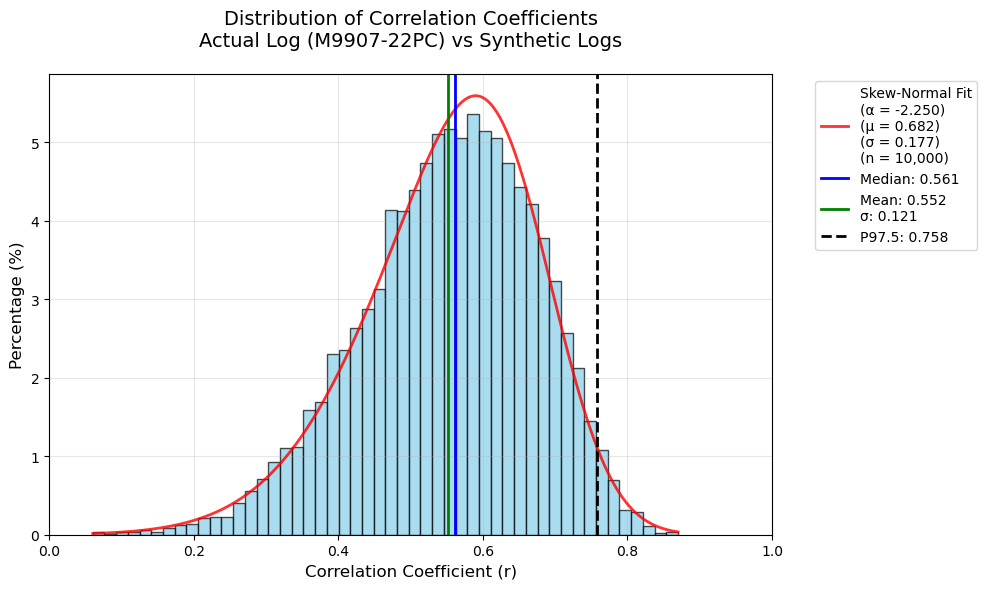

100%|██████████| 10000/10000 [00:18<00:00, 536.95it/s]


R-values data saved as: outputs/r-values_CSZ_Null_Hypothesis_logsyn_M9907-23PC.csv
Figure saved as: outputs/r-values_CSZ_Null_Hypothesis_logsyn_M9907-23PC.png

Summary Statistics for log_vs_synthetic Correlation Coefficients:
Number of correlations: 10,000
Median: 0.477
Mean: 0.470
Standard Deviation: 0.122
Min: 0.007
Max: 0.830
95th percentile: 0.689
99th percentile: 0.718

Distribution Fitting Results (skew-normal):
Shape parameter (α): -1.39645 (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)
Location parameter (μ): 0.57440 (Center/peak position of the distribution; larger magnitude shifts distribution)
Scale parameter (σ): 0.16029 (Width/spread of the distribution; magnitude indicates the degree of spread)
Skewness: -0.64871 (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)


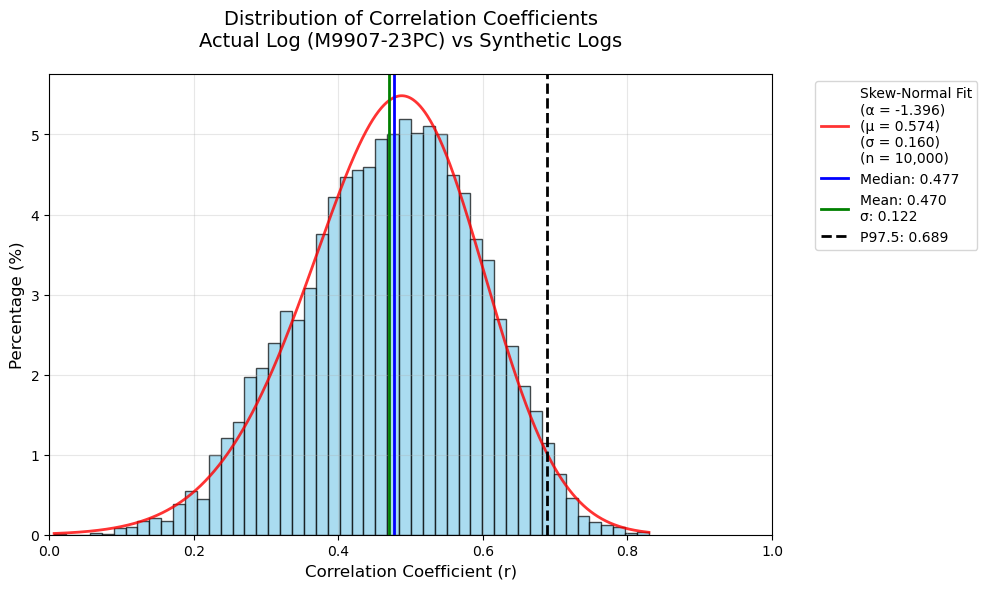

100%|██████████| 10000/10000 [00:20<00:00, 494.40it/s]


R-values data saved as: outputs/r-values_CSZ_Null_Hypothesis_logsyn_M9907-25PC.csv
Figure saved as: outputs/r-values_CSZ_Null_Hypothesis_logsyn_M9907-25PC.png

Summary Statistics for log_vs_synthetic Correlation Coefficients:
Number of correlations: 10,000
Median: 0.428
Mean: 0.425
Standard Deviation: 0.101
Min: 0.062
Max: 0.778
95th percentile: 0.613
99th percentile: 0.644

Distribution Fitting Results (skew-normal):
Shape parameter (α): -1.09660 (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)
Location parameter (μ): 0.49844 (Center/peak position of the distribution; larger magnitude shifts distribution)
Scale parameter (σ): 0.12456 (Width/spread of the distribution; magnitude indicates the degree of spread)
Skewness: -0.58956 (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)


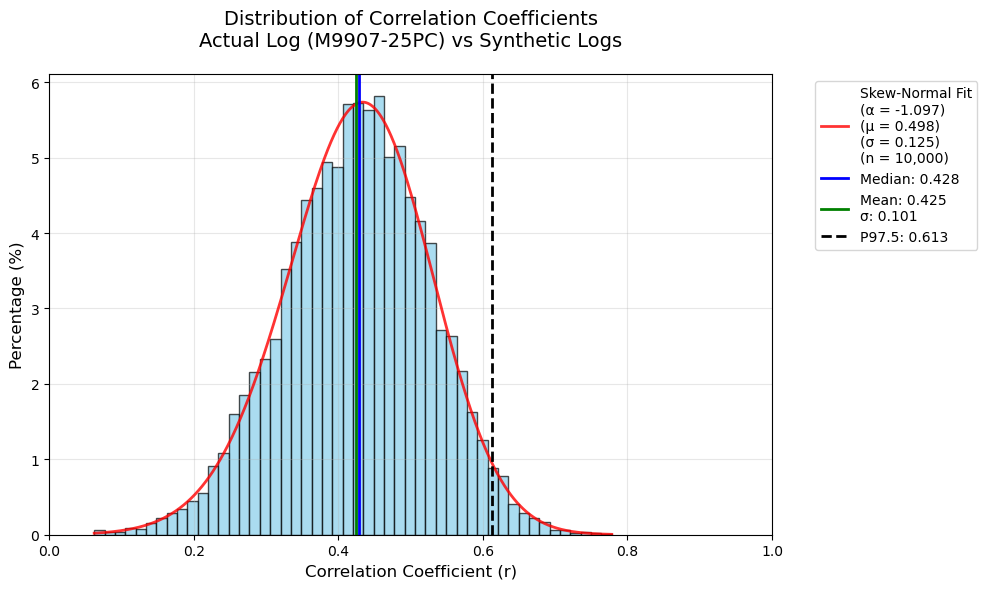

In [167]:
# core_numbers = ["22", "23", "25", "11", "12", "14", "56", "02", "30", "31", "09"]
core_numbers = ["22", "23", "25"]

for core_number in core_numbers:
    md_var = f"md_{core_number}"
    ms_var = f"ms_{core_number}" 
    r_values_logsyn = correlate_log_w_synthetic_logs(locals()[md_var], locals()[ms_var], np.max(locals()[md_var]), 10000, 0.3, turb_logs, depth_logs)

    core_name = f"core_name_{core_number}"

    # Plot log-synthetic correlations
    fig2, ax2, fit_params2 = plot_turbidite_correlation_distribution(
        r_values_data=r_values_logsyn,
        data_type="log_vs_synthetic",   #log_to_shuffled, log_to_synthetic, synthetic_to_synthetic
        pdf_method='skew-normal',               #'KDE', 'skew-normal', 'normal'
        kde_bandwidth=0.1,              #only work for KDE pdf_method
        save_figure=True,
        figure_name=f"outputs/r-values_CSZ_Null_Hypothesis_logsyn_{locals()[core_name]}.png",
        core_name=locals()[core_name],
        save_csv=True,
        csv_name=f"outputs/r-values_CSZ_Null_Hypothesis_logsyn_{locals()[core_name]}.csv"
    )

100%|██████████| 10000/10000 [00:14<00:00, 683.56it/s]


R-values data saved as: outputs/r-values_CSZ_Null_Hypothesis_synsyn.csv
Figure saved as: outputs/r-values_CSZ_Null_Hypothesis_synsyn.png

Summary Statistics for synthetic_to_synthetic Correlation Coefficients:
Number of correlations: 10,000
Median: 0.510
Mean: 0.503
Standard Deviation: 0.109
Min: -0.018
Max: 0.819
95th percentile: 0.699
99th percentile: 0.730

Distribution Fitting Results (skew-normal):
Shape parameter (α): -1.73097 (Asymmetry; α=0 gives normal distribution; positive α = right skew, negative α = left skew; magnitude indicates strength of skew)
Location parameter (μ): 0.60808 (Center/peak position of the distribution; larger magnitude shifts distribution)
Scale parameter (σ): 0.15160 (Width/spread of the distribution; magnitude indicates the degree of spread)
Skewness: -0.69088 (Measure of asymmetry; positive = longer right tail; magnitude indicates severity of skew)


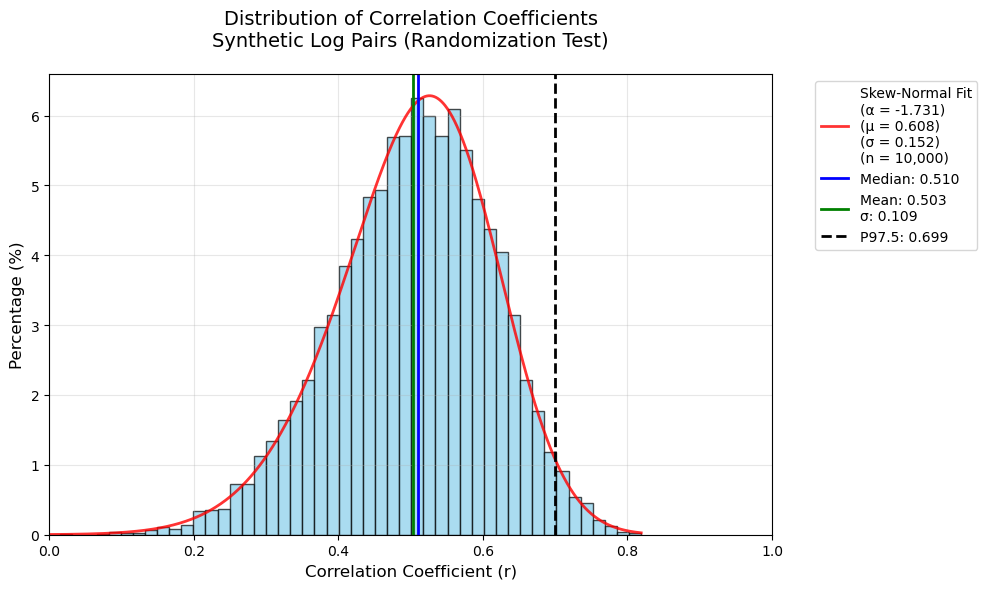

In [168]:
# compute r values for 1000000 synthetic log pairs (this is better than correlating actual logs with synthetic logs)
r_values_synsyn = correlate_synth_log_w_synth_logs(700, 10000, 0.3, turb_logs, depth_logs)

# plot the distribution of r values
fig1, ax1, fit_params1 = plot_turbidite_correlation_distribution(
    r_values_data=r_values_synsyn,
    data_type="synthetic_to_synthetic",  #log_to_shuffled, log_to_synthetic, synthetic_to_synthetic
    pdf_method='skew-normal',                    #'KDE', 'skew-normal', 'normal'
    kde_bandwidth=0.1,                   #only work for KDE pdf_method
    save_figure=True,
    figure_name="outputs/r-values_CSZ_Null_Hypothesis_synsyn.png",
    save_csv=True,
    csv_name="outputs/r-values_CSZ_Null_Hypothesis_synsyn.csv"
)

In [169]:
df = pd.DataFrame(r_values_dict, index = ['r values'])

In [170]:
len(turb_logs) # 90 turbidites

102

In [171]:
# create datafrme of r values of core correlations
df = pd.DataFrame(r_values_dict, index = ['r values'])

In [172]:
df

22-23     23-25     25-22     23-12     12-11     23-14  \
r values  0.734266  0.334142  0.539572  0.321598  0.371818  0.595517   

             56-31     30-31  
r values  0.638185  0.751057

In [173]:
df2 = pd.read_csv('/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/Cascade_well_list.csv')
df2.head()

Unnamed: 0    wellname        x (m)        y (m)  top (cm)  base (cm)  \
0           1  M9907-01PC  323155.4523  5094231.965       3.0      217.0   
1           2  M9907-02TC  322976.8965  5092876.617       3.0      153.0   
2           3  M9907-03PC  323444.5234  5093790.767       3.0      348.0   
3           4  M9907-05TC  248942.3983  5280304.395       1.0      230.0   
4           5  M9907-09TC  223659.7642  5349668.355       1.0      249.0   

   kb elevation (m) CT scan  Photo image  
0                 0     Yes          NaN  
1                 0     Yes          NaN  
2                 0     Yes          NaN  
3                 0     Yes          NaN  
4                 0     Yes          NaN

In [174]:
df2['x (m)'][df2['wellname'] == 'M9907-23PC'].values[0]

np.float64(164836.4388)

In [175]:
def compute_dist(wname1, wname2, df):
    # compute distnace between two cores
    x1 = df['x (m)'][df['wellname'] == wname1].values[0]
    y1 = df['y (m)'][df['wellname'] == wname1].values[0]
    x2 = df['x (m)'][df['wellname'] == wname2].values[0]
    y2 = df['y (m)'][df['wellname'] == wname2].values[0]
    dist = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    return dist

compute_dist('M9907-22PC', 'M9907-23PC', df2)

np.float64(4.262547567105501)

In [176]:
# lists of core names for correlated core pairs
wnames1 = ['M9907-22PC', 'M9907-23PC', 'M9907-25PC', 'M9907-23PC', 'M9907-12PC', 'M9907-23PC', 'RR0207-56PC', 'M9907-30PC']
wnames2 = ['M9907-23PC', 'M9907-25PC', 'M9907-22PC', 'M9907-12PC', 'M9907-11PC', 'M9907-14TC', 'M9907-31PC', 'M9907-31PC']

In [177]:
# distances between core pairs
dists = {}
for wname1, wname2, colname in zip(wnames1, wnames2, df.columns):
    dists[colname] = compute_dist(wname1, wname2, df2)
dists

{'22-23': np.float64(4.262547567105501),
 '23-25': np.float64(9511.690019966634),
 '25-22': np.float64(9515.952274584322),
 '23-12': np.float64(303287.693331802),
 '12-11': np.float64(11.700880736187145),
 '23-14': np.float64(252323.17211422455),
 '56-31': np.float64(248306.88838134793),
 '30-31': np.float64(1882.0695570917978)}

In [178]:
# dataframe of distances
df3 = pd.DataFrame(dists, index = ['distance (m)'])
df3

22-23       23-25        25-22          23-12      12-11  \
distance (m)  4.262548  9511.69002  9515.952275  303287.693332  11.700881   

                      23-14          56-31        30-31  
distance (m)  252323.172114  248306.888381  1882.069557

In [179]:
# add distances to dataframe of r values
df = pd.concat([df, df3], axis=0)
df

22-23        23-25        25-22          23-12      12-11  \
r values      0.734266     0.334142     0.539572       0.321598   0.371818   
distance (m)  4.262548  9511.690020  9515.952275  303287.693332  11.700881   

                      23-14          56-31        30-31  
r values           0.595517       0.638185     0.751057  
distance (m)  252323.172114  248306.888381  1882.069557

In [180]:
# comoute p values
r_values = np.array(r_values_synsyn)
p_values = {}
for colname, r_value in zip(df.columns, df.iloc[0]):
    p_values[colname] = len(r_values[r_values > r_value])/10000

In [181]:
df2 = pd.DataFrame(p_values, index = ['p values'])
df2

22-23  23-25   25-22  23-12   12-11   23-14   56-31   30-31
p values  0.0089  0.928  0.3924  0.942  0.8793  0.2063  0.1004  0.0041

In [182]:
# add p values to dataframe
df = pd.concat([df, df2], axis=0)
df

22-23        23-25        25-22          23-12      12-11  \
r values      0.734266     0.334142     0.539572       0.321598   0.371818   
distance (m)  4.262548  9511.690020  9515.952275  303287.693332  11.700881   
p values      0.008900     0.928000     0.392400       0.942000   0.879300   

                      23-14          56-31        30-31  
r values           0.595517       0.638185     0.751057  
distance (m)  252323.172114  248306.888381  1882.069557  
p values           0.206300       0.100400     0.004100

In [183]:
# final version of dataframe
df = df.transpose()
df

r values   distance (m)  p values
22-23  0.734266       4.262548    0.0089
23-25  0.334142    9511.690020    0.9280
25-22  0.539572    9515.952275    0.3924
23-12  0.321598  303287.693332    0.9420
12-11  0.371818      11.700881    0.8793
23-14  0.595517  252323.172114    0.2063
56-31  0.638185  248306.888381    0.1004
30-31  0.751057    1882.069557    0.0041

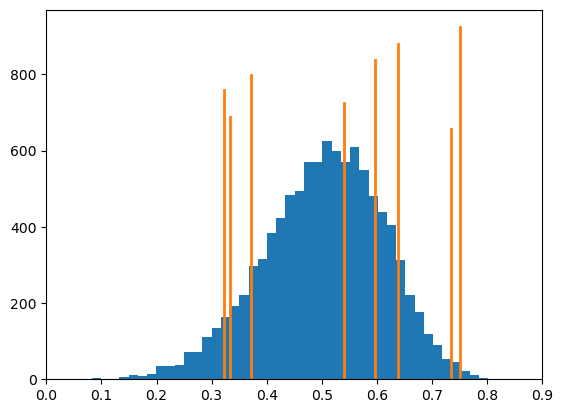

In [184]:
plt.figure()
plt.hist(r_values, 50)
cmap = plt.get_cmap("tab10")
for r_value in df['r values']:
    plt.plot([r_value, r_value], [0, plt.gca().get_ylim()[1]], color=cmap(1), linewidth = 2)
plt.xlim(0, 0.9)
plt.ylim(0, plt.gca().get_ylim()[1]);

In [185]:
df.to_csv('p_values_of_correlations.csv')

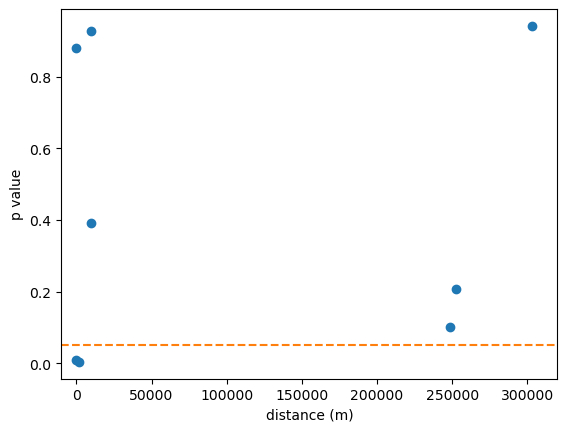

In [186]:
plt.figure()
plt.scatter(df['distance (m)'], df['p values'])
plt.plot([-10000, 320000], [0.05, 0.05], '--', color=cmap(1))
plt.xlim(-10000, 320000)
plt.xlabel('distance (m)')
plt.ylabel('p value');